In [2]:
import re#context window size 5
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import pickle
import gc
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import os
from tqdm import tqdm

DATASET_PATH = r"D:\Heisenber\simplewiki.txt"
GLOVE_PATH = r"C:\Users\Asus\Desktop\Heisenber\glove.6B.100d.txt"
EMB_DIM = 100
MAX_SAMPLES = 200_000
VOCAB_SIZE = 10000
WINDOW_SIZE = 5 
MODEL_SAVE_PATH = "nextword_model.pkl"
BPE_TOKENIZER_PATH = "bpe_tokenizer.json"

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)
        smoothed_targets = targets * (1 - self.label_smoothing) + self.label_smoothing / num_classes
        
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class NextWordDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def calculate_topk_accuracy(y_true, y_pred_probs, k_values=[1, 5, 10]):
    accuracies = {}
    
    for k in k_values:
        top_k_preds = np.argsort(y_pred_probs, axis=1)[:, -k:]
        
        correct = 0
        for i, true_label in enumerate(y_true):
            if true_label in top_k_preds[i]:
                correct += 1
        
        accuracies[f'top_{k}'] = correct / len(y_true)
    
    return accuracies

class EnhancedNextWordPredictor:
    def __init__(self, vocab_size=10000, window_size=5, emb_dim=100):
        self.vocab_size = vocab_size
        self.window_size = window_size
        self.emb_dim = emb_dim
        self.tokenizer = None
        self.token_to_idx = None
        self.idx_to_token = None
        self.token_freq = None
        self.glove_embeddings = None
        self.glove_dict = None  
        self.model = None
        self.scaler = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        print(f"Context window size: {self.window_size}")
        
    def load_dataset(self, dataset_path, max_lines=None):

        
        try:
            sentences = []
            with open(dataset_path, 'r', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if max_lines and i >= max_lines:
                        break
                    
                    line = line.strip()
                    if not line:
                        continue
                    
                    # Clean text
                    line = re.sub(r'[^\w\s.,!?;:\'"-]', ' ', line)
                    line = re.sub(r'\s+', ' ', line)
                    line = line.lower()
                    
                    # Filter by length
                    words = line.split()
                    if 6 <= len(words) <= 30: 
                        sentences.append(line)
            
            # Remove duplicates and sort
            sentences = list(set(sentences))
            sentences.sort(key=lambda x: (len(x.split()), x))
            
            print(f"Loaded {len(sentences)} unique sentences")
            return sentences
            
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None
    
    def train_bpe_tokenizer(self, sentences):


        self.tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
        self.tokenizer.pre_tokenizer = Whitespace()

        trainer = BpeTrainer(
            vocab_size=self.vocab_size,
            min_frequency=3,
            special_tokens=["<PAD>", "<UNK>", "<START>", "<END>"],
            show_progress=True
        )

        self.tokenizer.train_from_iterator(sentences, trainer)
        self.tokenizer.save(BPE_TOKENIZER_PATH)

        vocab = self.tokenizer.get_vocab()
        self.token_to_idx = vocab
        self.idx_to_token = {v: k for k, v in vocab.items()}
        
        print(f"BPE tokenizer trained with {len(vocab)} tokens")
        return True

    def tokenize_texts(self, sentences):
        token_list = []
        
        for sentence in tqdm(sentences, desc="Tokenizing"):
            tokens = self.tokenizer.encode(sentence).tokens
            token_list.extend(tokens)
        
        # Store token frequencies for confidence scoring
        self.token_freq = dict(Counter(token_list))
        
        return token_list

    def get_subword_embedding(self, token):

        if not self.glove_dict:
            return np.random.normal(0, 0.03, self.emb_dim)

        if token in self.glove_dict:
            return self.glove_dict[token]

        if token.lower() in self.glove_dict:
            return self.glove_dict[token.lower()]

        if token.startswith('Ġ'): 
            clean_token = token[1:]
            if clean_token in self.glove_dict:
                return self.glove_dict[clean_token]
            if clean_token.lower() in self.glove_dict:
                return self.glove_dict[clean_token.lower()]
        

        if len(token) >= 3:

            candidates = [word for word in self.glove_dict.keys() 
                         if word.endswith(token) and len(word) > len(token)]
            if candidates:

                return self.glove_dict[candidates[0]]

        if len(token) >= 2:
            similar_words = [word for word in self.glove_dict.keys() 
                           if len(word) >= 2 and (
                               word.startswith(token[:2]) or 
                               word.endswith(token[-2:])
                           )][:5]
            
            if similar_words:
                embeddings = [self.glove_dict[word] for word in similar_words]
                return np.mean(embeddings, axis=0)

        return np.random.normal(0, 0.03, self.emb_dim)

    def load_glove_embeddings(self):

        
        if not os.path.exists(GLOVE_PATH):
            print(f"GloVe file not found. Using random embeddings.")
            self.glove_embeddings = np.random.normal(0, 0.1, (len(self.token_to_idx), self.emb_dim))
            return
        
        self.glove_dict = {}
        
        try:
            with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
                for line in tqdm(f, desc="Loading GloVe"):
                    parts = line.strip().split()
                    if len(parts) == self.emb_dim + 1:
                        word = parts[0]
                        vector = np.array([float(x) for x in parts[1:]])
                        self.glove_dict[word] = vector
                        
        except Exception as e:
            print(f"Error loading GloVe: {e}")
            self.glove_embeddings = np.random.normal(0, 0.1, (len(self.token_to_idx), self.emb_dim))
            return
        
        print(f"Loaded {len(self.glove_dict)} GloVe vectors")
        
        # Initialize embeddings matrix
        self.glove_embeddings = np.random.normal(0, 0.03, (len(self.token_to_idx), self.emb_dim))
        
        # Map tokens to embeddings using enhanced subword handling
        found_count = 0
        for token, idx in tqdm(self.token_to_idx.items(), desc="Mapping embeddings"):
            embedding = self.get_subword_embedding(token)
            self.glove_embeddings[idx] = embedding
            
            # Count as "found" if not completely random
            if token in self.glove_dict or token.lower() in self.glove_dict:
                found_count += 1
        
        coverage = found_count / len(self.token_to_idx) * 100
        print(f"Direct GloVe coverage: {found_count}/{len(self.token_to_idx)} tokens ({coverage:.1f}%)")
     
    
    def create_exponential_weighted_features(self, context_tokens):

        if len(context_tokens) != self.window_size:
            return None

        context_indices = [self.token_to_idx.get(token, self.token_to_idx['<UNK>']) 
                          for token in context_tokens]
        context_embeddings = self.glove_embeddings[context_indices]
        

        positions = np.arange(self.window_size)
        alpha = 0.3 
        exp_weights = np.exp(-alpha * (self.window_size - 1 - positions))
        exp_weights = exp_weights / np.sum(exp_weights) 
        
    
        exponential_weighted_avg = np.average(context_embeddings, weights=exp_weights, axis=0)
        

        return exponential_weighted_avg
    
    def create_training_samples(self, tokens):

        
        X_features = []
        y_labels = []

        valid_tokens = [token for token in tokens if token in self.token_to_idx]
        print(f"Valid tokens: {len(valid_tokens)}/{len(tokens)}")

        sample_indices = list(range(self.window_size, min(len(valid_tokens), MAX_SAMPLES + self.window_size)))
        
        for i in tqdm(sample_indices, desc="Creating samples"):
            if i >= len(valid_tokens):
                break
                
            target_token = valid_tokens[i]
            # Context from i-window_size to i-1 (for i-th target)
            context_tokens = valid_tokens[i - self.window_size:i]
            
            features = self.create_exponential_weighted_features(context_tokens)
            if features is None:
                continue
            
            X_features.append(features)
            y_labels.append(self.token_to_idx[target_token])
        
        X = np.array(X_features, dtype=np.float32)
        y = np.array(y_labels)
        
        print(f"Created {len(X)} samples with {X.shape[1]} features (should be {self.emb_dim})")
        assert X.shape[1] == self.emb_dim, f"Expected {self.emb_dim} features, got {X.shape[1]}"
        
        # Class distribution analysis
        unique_classes, counts = np.unique(y, return_counts=True)
        print(f"Classes: {len(unique_classes)}, Min samples: {counts.min()}, Max: {counts.max()}")
        
        return X, y
    
    def train_model(self, X, y):

        # Filter classes with minimum samples
        class_counts = Counter(y)
        min_samples = 5
        mask = np.array([class_counts[label] >= min_samples for label in y])
        X_filtered = X[mask]
        y_filtered = y[mask]
        
        print(f"After filtering: {len(X_filtered)} samples, {len(np.unique(y_filtered))} classes")

        unique_labels = np.unique(y_filtered)
        label_map = {old: new for new, old in enumerate(unique_labels)}
        y_mapped = np.array([label_map[label] for label in y_filtered])
        
        # Data split
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42
        )
        
        # Scaling
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Datasets
        train_dataset = NextWordDataset(X_train_scaled, y_train)
        test_dataset = NextWordDataset(X_test_scaled, y_test)
        
        batch_size = min(256, len(X_train_scaled) // 10)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        

        input_size = X_train_scaled.shape[1] 
        num_classes = len(unique_labels)
        
        self.model = nn.Sequential(
            # First hidden layer
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),
            
            # Second hidden layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            
            # Third hidden layer
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(256),
            
            # Fourth hidden layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Output layer
            nn.Linear(128, num_classes)
        ).to(self.device)

        self.label_map = label_map
        self.reverse_label_map = {v: k for k, v in label_map.items()}

        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # More epochs for better accuracy
        num_epochs = 60
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=0.003, epochs=num_epochs, steps_per_epoch=len(train_loader)
        )
        
        best_test_acc = 0
        best_metrics = {}
        

        
        for epoch in range(num_epochs):
 
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()

            self.model.eval()
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    outputs = self.model(batch_X)
                    probs = torch.softmax(outputs, dim=1)
                    
                    all_preds.append(probs.cpu().numpy())
                    all_labels.extend(batch_y.cpu().numpy())
        
            all_preds = np.vstack(all_preds)
            all_labels = np.array(all_labels)
            metrics = calculate_topk_accuracy(all_labels, all_preds, k_values=[1, 5, 10])
            
            train_acc = train_correct / train_total
            
            if metrics['top_1'] > best_test_acc:
                best_test_acc = metrics['top_1']
                best_metrics = metrics.copy()
                torch.save(self.model.state_dict(), 'best_model.pth')
            
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f'Epoch {epoch}: Train: {train_acc:.3f}, '
                      f'Top-1: {metrics["top_1"]:.3f}, '
                      f'Top-5: {metrics["top_5"]:.3f}, '
                      f'Top-10: {metrics["top_10"]:.3f}')
        

        self.model.load_state_dict(torch.load('best_model.pth'))
        print(f"\nBest metrics:")
        print(f"Top-1 accuracy: {best_metrics['top_1']:.1%}")
        print(f"Top-5 accuracy: {best_metrics['top_5']:.1%}")
        print(f"Top-10 accuracy: {best_metrics['top_10']:.1%}")
        
        return best_metrics
    
    def predict_next_word(self, text, top_k=10):

        if self.model is None:
            raise ValueError("Model not trained!")

        tokens = self.tokenizer.encode(text.lower()).tokens
        
        if len(tokens) < self.window_size:
            padding_needed = self.window_size - len(tokens)
            if tokens:

                pad_token = "<PAD>" if "<PAD>" in self.token_to_idx else tokens[-1]
                tokens = [pad_token] * padding_needed + tokens
            else:
                return None

        context_tokens = tokens[-self.window_size:]

        features = self.create_exponential_weighted_features(context_tokens)
        if features is None:
            return None
        

        features_scaled = self.scaler.transform([features])
    
        self.model.eval()
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features_scaled).to(self.device)
            outputs = self.model(features_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

        top_indices = np.argsort(probs)[-top_k:][::-1]
        predictions = []
        
        for idx in top_indices:
            if idx < len(self.reverse_label_map):
                original_idx = self.reverse_label_map[idx]
                token = self.idx_to_token[original_idx]
                confidence = probs[idx]
                freq = self.token_freq.get(token, 0)
                
                predictions.append((token, confidence, freq))
        
        return predictions

def get_test_sentences_for_window_experiment():

    test_sentences = {
        'short': [
            # 5-7 words - good for small windows (3, 5)
            "the cat sat on the mat",
            "i like to eat pizza sometimes",
            "she went to the store today",
            "artificial intelligence is becoming very popular",
            "students should study hard for exams"
        ],
        'medium': [
            # 8-12 words - good for medium windows (5, 7)
            "the quick brown fox jumped over the lazy dog yesterday",
            "machine learning algorithms are becoming increasingly sophisticated and powerful in many applications",
            "after a long day at work she decided to relax and watch",
            "the weather forecast predicted heavy rain and strong winds for the entire",
            "artificial intelligence will revolutionize the way we think about technology and automation",
            "students in the computer science program are learning advanced concepts about data structures"
        ],
        'long': [
            # 13-20 words - good for large windows (7, 10)
            "the research team at the university has been working on developing new machine learning algorithms for natural language processing applications",
            "during the global pandemic many companies had to quickly adapt their business models and transition to remote work environments for employee safety",
            "the professor explained that understanding the mathematical foundations of artificial intelligence requires knowledge of linear algebra statistics and calculus among other subjects",
            "climate change researchers are using advanced computer models and satellite data to better understand and predict future environmental changes across different regions",
            "the software engineering team spent several months designing and implementing a scalable distributed system that could handle millions of concurrent users effectively",
            "after graduating from university with a degree in computer science she decided to pursue advanced studies in machine learning and data science"
        ],
        'very_long': [
            # 20+ words - excellent for large windows (10+)
            "the international conference on artificial intelligence brought together researchers from universities and technology companies around the world to discuss the latest developments in machine learning natural language processing computer vision and robotics",
            "the startup company founded by former google engineers has developed an innovative approach to solving complex optimization problems using quantum computing algorithms and has recently secured significant funding from venture capital firms",
            "the comprehensive study published in the journal of machine learning research analyzed the performance of various deep learning architectures on natural language understanding tasks and found that transformer based models consistently outperformed traditional approaches",
            "the government announced new regulations for artificial intelligence systems used in healthcare financial services and autonomous vehicles to ensure safety privacy and fairness while promoting innovation and technological advancement in these critical sectors"
        ]
    }
    return test_sentences

def experiment_with_window_sizes():

    window_sizes = [3, 5, 7, 10]
    results = {}
    
    for window_size in window_sizes:
        print(f"\n{'='*50}")
        print(f"EXPERIMENTING WITH WINDOW SIZE: {window_size}")
        print(f"{'='*50}")
        
        predictor = EnhancedNextWordPredictor(
            vocab_size=VOCAB_SIZE,
            window_size=window_size,
            emb_dim=EMB_DIM
        )
        
        # Load and process data
        sentences = predictor.load_dataset(DATASET_PATH, max_lines=50000) 
        if not sentences:
            continue
            
        predictor.train_bpe_tokenizer(sentences)
        predictor.load_glove_embeddings()
        tokens = predictor.tokenize_texts(sentences)
        X, y = predictor.create_training_samples(tokens)
        
        # Train model
        metrics = predictor.train_model(X, y)
        results[window_size] = metrics
        
        # Test with appropriate sentences for this window size
        test_sentences = get_test_sentences_for_window_experiment()
        
        print(f"\nTESTING WINDOW SIZE {window_size}")
        
        # Choose appropriate test sentences based on window size
        if window_size <= 5:
            test_set = test_sentences['short'] + test_sentences['medium'][:2]
        elif window_size <= 7:
            test_set = test_sentences['medium'] + test_sentences['long'][:2]
        else:
            test_set = test_sentences['long'] + test_sentences['very_long'][:2]
        
        for i, context in enumerate(test_set[:5]): 
            words_in_context = len(context.split())
            print(f"\nContext ({words_in_context} words): '{context}'")
            
            if words_in_context >= window_size:
                preds = predictor.predict_next_word(context, top_k=5)
                if preds:
                    result = ", ".join(f"{token}({conf:.3f})" for token, conf, _ in preds)
                    print(f"Predictions: {result}")
                else:
                    print("No predictions available")
            else:
                print(f"⚠️  Context too short for window size {window_size} (needs {window_size}, has {words_in_context})")

        del predictor, sentences, tokens, X, y
        gc.collect()
    
    # Print comparison
    print(f"\n{'='*60}")
    print("WINDOW SIZE COMPARISON RESULTS")
    print(f"{'='*60}")
    print(f"{'Window':<8} {'Top-1':<8} {'Top-5':<8} {'Top-10':<8}")
    print("-" * 35)
    for window_size, metrics in results.items():
        print(f"{window_size:<8} {metrics['top_1']:.1%:<8} {metrics['top_5']:.1%:<8} {metrics['top_10']:.1%}")
    
    return results

def main():

    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset not found at {DATASET_PATH}")
        return
    
    # Uncomment the line below to experiment with different window sizes
    experiment_with_window_sizes()
    # return
    
    predictor = EnhancedNextWordPredictor(
        vocab_size=VOCAB_SIZE,
        window_size=WINDOW_SIZE,
        emb_dim=EMB_DIM
    )
    
    try:
        # Load and process data
        sentences = predictor.load_dataset(DATASET_PATH, max_lines=100000)
        if not sentences:
            return

        predictor.train_bpe_tokenizer(sentences)
        predictor.load_glove_embeddings()
        tokens = predictor.tokenize_texts(sentences)
        X, y = predictor.create_training_samples(tokens)
        del sentences, tokens
        gc.collect()

  
        metrics = predictor.train_model(X, y)
        
 
        test_sentences_dict = get_test_sentences_for_window_experiment()

        test_contexts = (test_sentences_dict['short'] + 
                        test_sentences_dict['medium'] + 
                        test_sentences_dict['long'][:3] + 
                        test_sentences_dict['very_long'][:2])
        
        print(f"Testing with {len(test_contexts)} sentences of varying lengths...")
        
        print("\n=== PREDICTIONS WITH EXPONENTIAL WEIGHTED FEATURES ===")
        for context in test_contexts:
            print(f"\nContext: '{context}'")
            
            # Top 5 predictions
            preds_5 = predictor.predict_next_word(context, top_k=5)
            if preds_5:
                result_5 = ", ".join(f"{token}({conf:.3f})" for token, conf, _ in preds_5)
                print(f"Top-5: {result_5}")
            
            # Top 10 predictions
            preds_10 = predictor.predict_next_word(context, top_k=10)
            if preds_10:
                result_10 = ", ".join(f"{token}({conf:.3f})" for token, conf, _ in preds_10[:10])
                print(f"Top-10: {result_10}")
        
        print(f"\n=== FINAL RESULTS ===")
        print(f"Feature Vector Size: 100x1 (exponential weighted average only)")
        print(f"Context Window Size: {WINDOW_SIZE}")
        print(f"Top-1 Accuracy: {metrics['top_1']:.1%}")
        print(f"Top-5 Accuracy: {metrics['top_5']:.1%}")
        print(f"Top-10 Accuracy: {metrics['top_10']:.1%}")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


EXPERIMENTING WITH WINDOW SIZE: 3
Using device: cpu
Context window size: 3
Loaded 13281 unique sentences
BPE tokenizer trained with 10000 tokens


Loading GloVe: 400000it [00:10, 38053.96it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:45<00:00, 95.05it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 21397.34it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:08<00:00, 23722.57it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10961
After filtering: 189834 samples, 5310 classes
Epoch 0: Train: 0.073, Top-1: 0.109, Top-5: 0.247, Top-10: 0.316
Epoch 10: Train: 0.159, Top-1: 0.165, Top-5: 0.338, Top-10: 0.416
Epoch 20: Train: 0.178, Top-1: 0.178, Top-5: 0.355, Top-10: 0.431
Epoch 30: Train: 0.192, Top-1: 0.185, Top-5: 0.360, Top-10: 0.437
Epoch 40: Train: 0.209, Top-1: 0.188, Top-5: 0.364, Top-10: 0.441
Epoch 50: Train: 0.223, Top-1: 0.192, Top-5: 0.367, Top-10: 0.444
Epoch 59: Train: 0.228, Top-1: 0.191, Top-5: 0.368, Top-10: 0.443

Best metrics:
Top-1 accuracy: 19.2%
Top-5 accuracy: 36.8%
Top-10 accuracy: 44.4%

TESTING WINDOW SIZE 3

Context (6 words): 'the cat sat on the mat'
Predictions: .(0.065), s(0.051), "(0.050), ,(0.046), of(0.035)

Context (6 words): 'i like to eat pizza sometimes'
Predictions: .(0.269), ,(0.124), that(0.034), and(0.031), to(0.026)

Context (6 words): 'she went to the store today'
Predictions

Loading GloVe: 400000it [00:07, 51376.83it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:40<00:00, 99.67it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 34751.68it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:07<00:00, 28187.41it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10961
After filtering: 189834 samples, 5310 classes
Epoch 0: Train: 0.072, Top-1: 0.102, Top-5: 0.242, Top-10: 0.311
Epoch 10: Train: 0.156, Top-1: 0.162, Top-5: 0.331, Top-10: 0.410
Epoch 20: Train: 0.174, Top-1: 0.175, Top-5: 0.346, Top-10: 0.423
Epoch 30: Train: 0.191, Top-1: 0.178, Top-5: 0.354, Top-10: 0.429
Epoch 40: Train: 0.207, Top-1: 0.183, Top-5: 0.358, Top-10: 0.432
Epoch 50: Train: 0.222, Top-1: 0.185, Top-5: 0.359, Top-10: 0.434
Epoch 59: Train: 0.227, Top-1: 0.186, Top-5: 0.359, Top-10: 0.433

Best metrics:
Top-1 accuracy: 18.6%
Top-5 accuracy: 35.9%
Top-10 accuracy: 43.3%

TESTING WINDOW SIZE 5

Context (6 words): 'the cat sat on the mat'
Predictions: .(0.104), is(0.073), ,(0.065), of(0.031), and(0.026)

Context (6 words): 'i like to eat pizza sometimes'
Predictions: .(0.121), plants(0.046), animals(0.037), the(0.037), their(0.035)

Context (6 words): 'she went to the store toda

Loading GloVe: 400000it [00:07, 51214.06it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:38<00:00, 101.19it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 35280.54it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:07<00:00, 28328.50it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10960
After filtering: 189834 samples, 5310 classes
Epoch 0: Train: 0.070, Top-1: 0.100, Top-5: 0.242, Top-10: 0.312
Epoch 10: Train: 0.154, Top-1: 0.162, Top-5: 0.330, Top-10: 0.408
Epoch 20: Train: 0.172, Top-1: 0.171, Top-5: 0.344, Top-10: 0.420
Epoch 30: Train: 0.189, Top-1: 0.178, Top-5: 0.350, Top-10: 0.427
Epoch 40: Train: 0.206, Top-1: 0.182, Top-5: 0.353, Top-10: 0.430
Epoch 50: Train: 0.221, Top-1: 0.183, Top-5: 0.355, Top-10: 0.428
Epoch 59: Train: 0.227, Top-1: 0.183, Top-5: 0.355, Top-10: 0.430

Best metrics:
Top-1 accuracy: 18.4%
Top-5 accuracy: 35.4%
Top-10 accuracy: 42.9%

TESTING WINDOW SIZE 7

Context (10 words): 'the quick brown fox jumped over the lazy dog yesterday'
Predictions: is(0.158), .(0.076), ,(0.067), in(0.022), was(0.019)

Context (12 words): 'machine learning algorithms are becoming increasingly sophisticated and powerful in many applications'
Predictions: ,(0.133

Loading GloVe: 400000it [00:07, 51979.16it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:43<00:00, 96.88it/s] 


Direct GloVe coverage: 8479/10000 tokens (84.8%)


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 36596.09it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:07<00:00, 26964.93it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10960
After filtering: 189834 samples, 5310 classes
Epoch 0: Train: 0.069, Top-1: 0.100, Top-5: 0.247, Top-10: 0.316
Epoch 10: Train: 0.154, Top-1: 0.161, Top-5: 0.332, Top-10: 0.408
Epoch 20: Train: 0.172, Top-1: 0.171, Top-5: 0.344, Top-10: 0.420
Epoch 30: Train: 0.188, Top-1: 0.177, Top-5: 0.352, Top-10: 0.429
Epoch 40: Train: 0.207, Top-1: 0.180, Top-5: 0.355, Top-10: 0.430
Epoch 50: Train: 0.222, Top-1: 0.181, Top-5: 0.354, Top-10: 0.431
Epoch 59: Train: 0.227, Top-1: 0.181, Top-5: 0.355, Top-10: 0.431

Best metrics:
Top-1 accuracy: 18.1%
Top-5 accuracy: 35.4%
Top-10 accuracy: 43.0%

TESTING WINDOW SIZE 10

Context (20 words): 'the research team at the university has been working on developing new machine learning algorithms for natural language processing applications'
Predictions: .(0.272), ,(0.163), are(0.032), that(0.027), is(0.026)

Context (22 words): 'during the global pandemic many

ValueError: Invalid format specifier '.1%:<8' for object of type 'float'

Enhanced Next-Word Predictor with Research Visualizations
Key Features:
• Exponential weighted average features only (100x1 vector)
• Context window from i-window_size to i-1 for i-th target
• Enhanced BPE subword embedding handling
• Comprehensive research visualizations
• Fixed format specifier error

Running comprehensive window size experiment...

EXPERIMENTING WITH WINDOW SIZE: 3
Using device: cpu
Context window size: 3
Feature vector size: 100x1 (exponential weighted average only)
Loaded 13281 unique sentences
BPE tokenizer trained with 10000 tokens


Loading GloVe: 400000it [00:20, 19553.81it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [03:51<00:00, 43.28it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)
Subword approximation coverage: 1295/10000 tokens (13.0%)
Total coverage: 97.7%
Top 10 uncovered frequent tokens: [('epis', 0), ('particip', 0), ('antarct', 0), ('behavi', 0), ('eties', 0), ('anch', 0), ('erife', 0), ('celon', 0), ('independ', 0), ('ired', 0)]


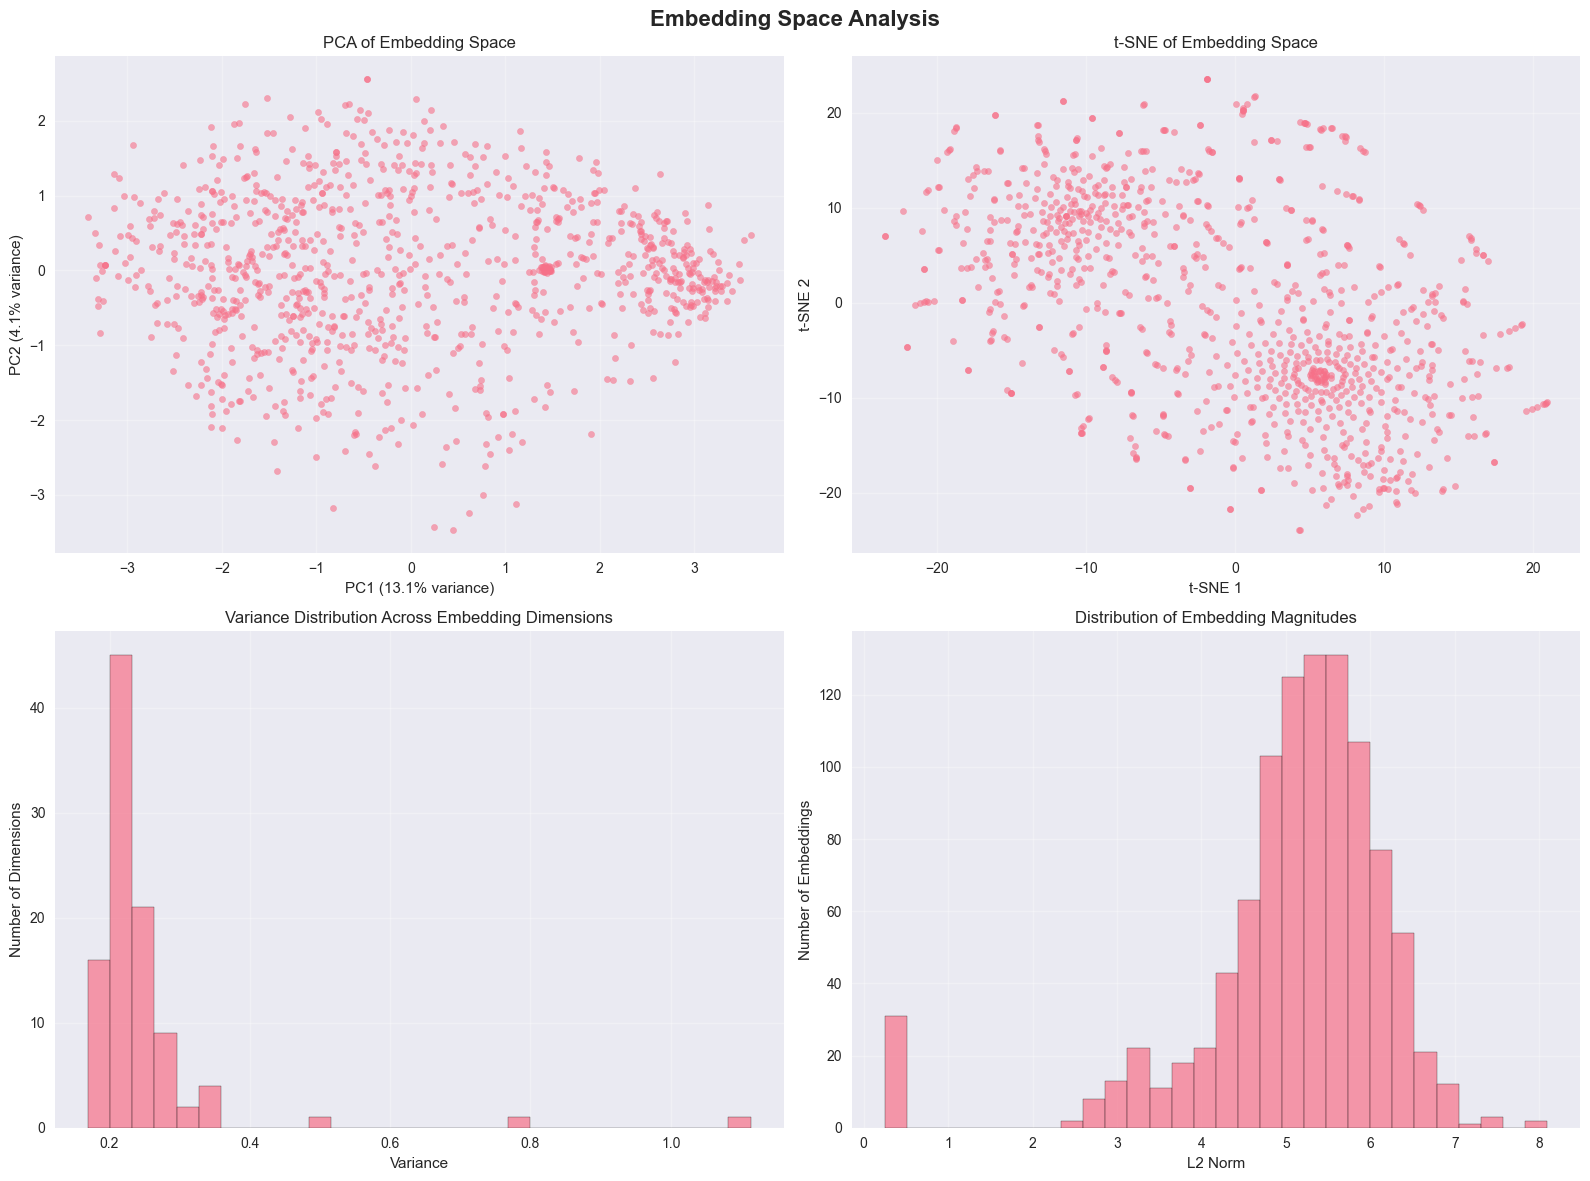

Tokenizing: 100%|██████████| 13281/13281 [00:01<00:00, 12821.63it/s]


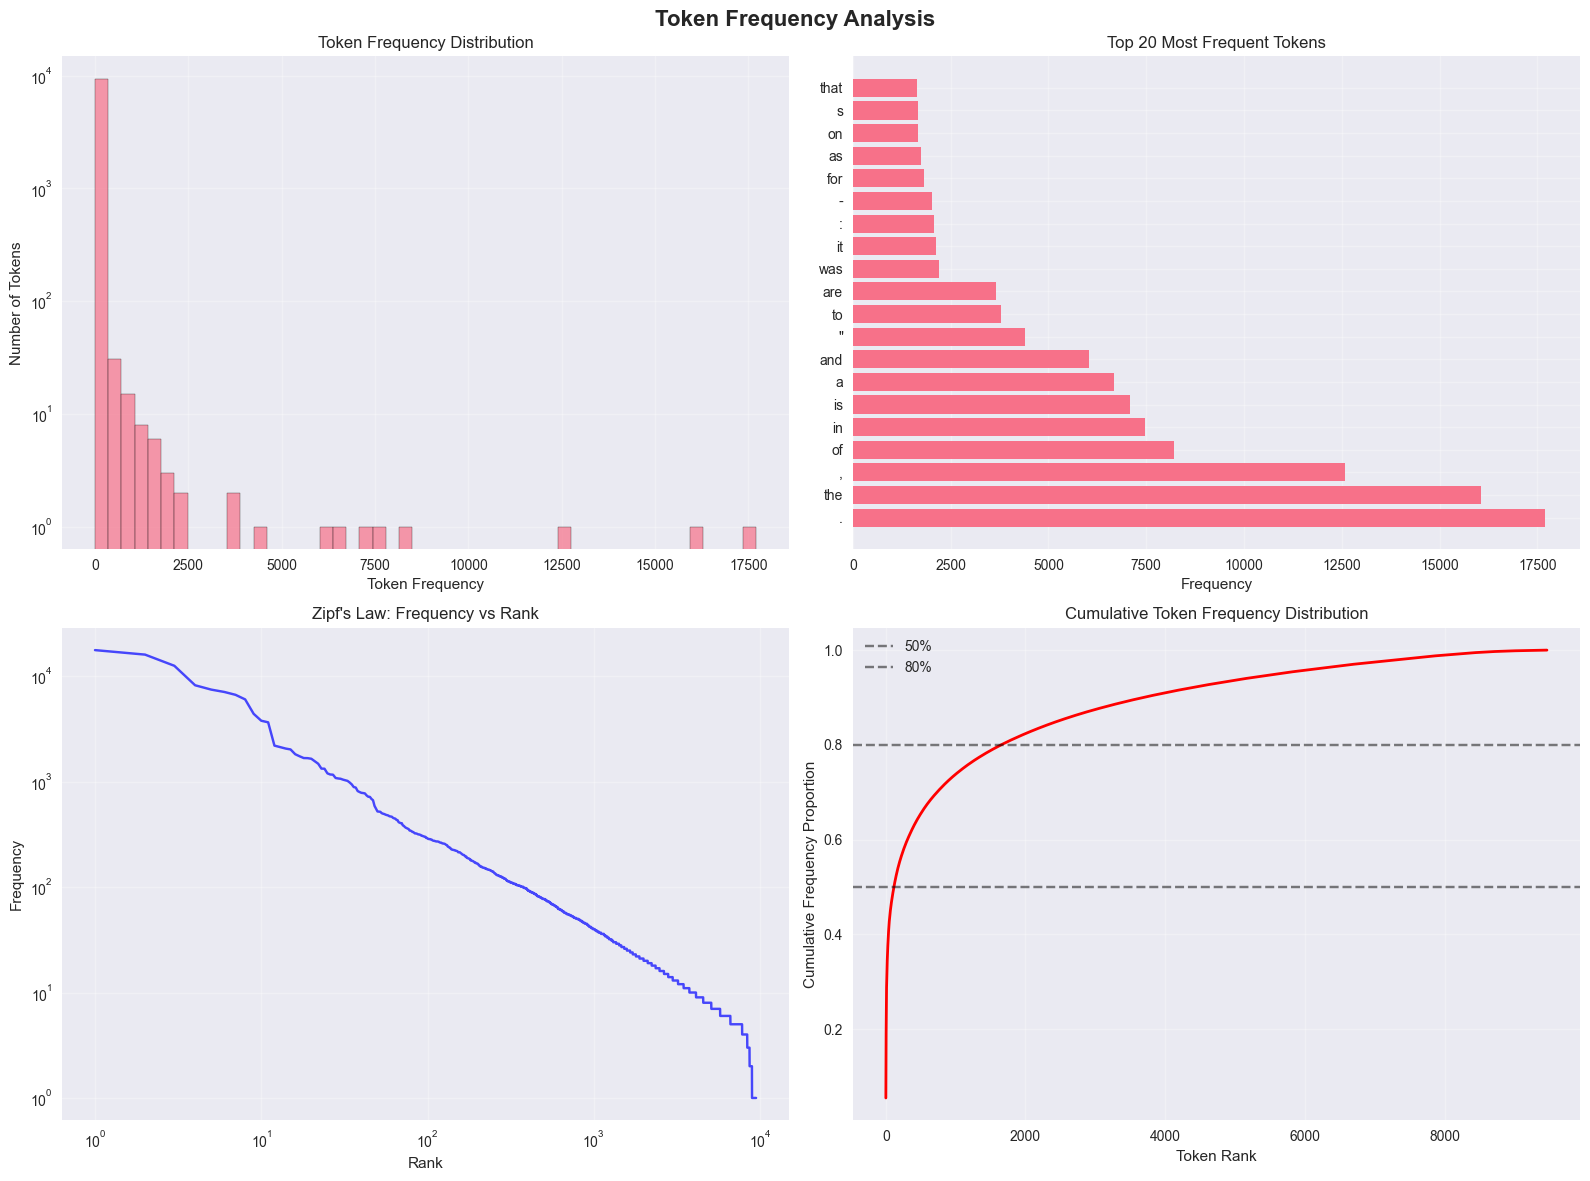

Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:19<00:00, 10299.19it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10961
After filtering: 189834 samples, 5310 classes
Epoch 0: Train Loss: 7.3452, Train Acc: 0.074, Top-1: 0.102, Top-5: 0.247, Top-10: 0.317
Epoch 10: Train Loss: 5.7788, Train Acc: 0.160, Top-1: 0.163, Top-5: 0.340, Top-10: 0.416
Epoch 20: Train Loss: 5.4158, Train Acc: 0.178, Top-1: 0.176, Top-5: 0.355, Top-10: 0.428
Epoch 30: Train Loss: 5.1770, Train Acc: 0.193, Top-1: 0.182, Top-5: 0.361, Top-10: 0.438
Epoch 40: Train Loss: 4.9883, Train Acc: 0.208, Top-1: 0.186, Top-5: 0.367, Top-10: 0.441
Epoch 50: Train Loss: 4.8488, Train Acc: 0.223, Top-1: 0.189, Top-5: 0.369, Top-10: 0.442
Epoch 59: Train Loss: 4.8026, Train Acc: 0.227, Top-1: 0.189, Top-5: 0.369, Top-10: 0.443

Best metrics:
Top-1 accuracy: 19.0%
Top-5 accuracy: 36.9%
Top-10 accuracy: 44.1%


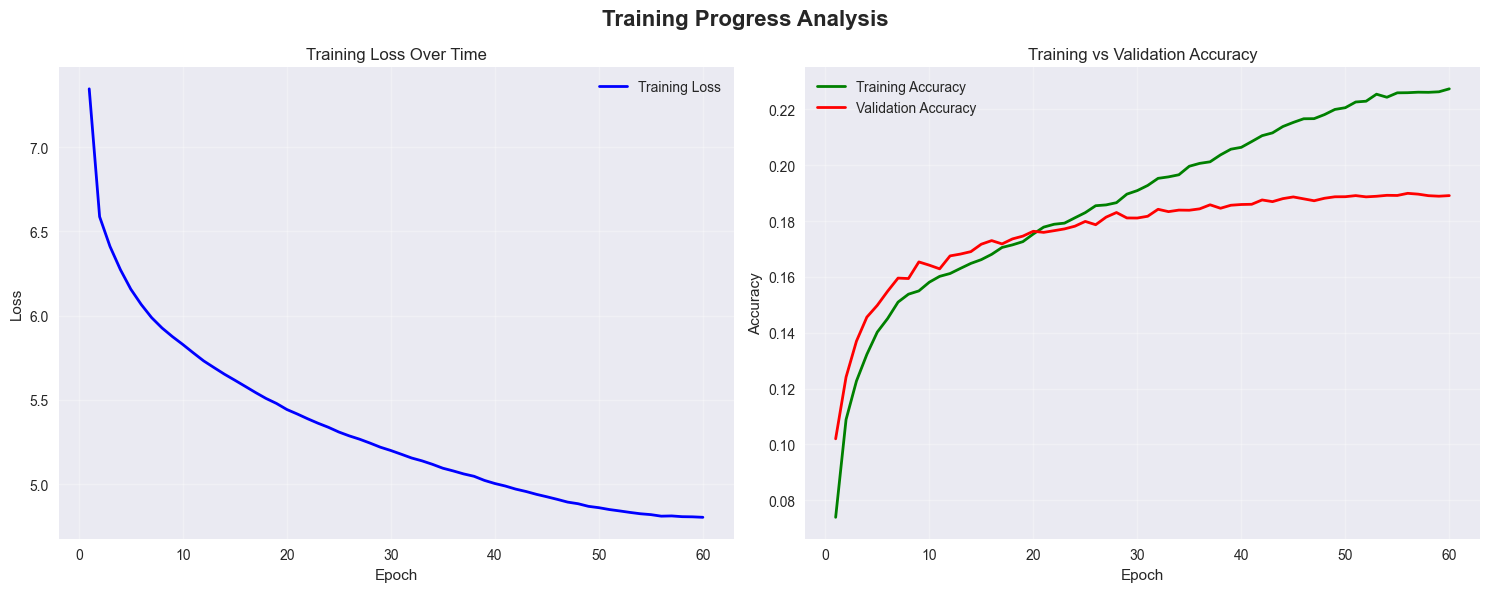


TESTING WINDOW SIZE 3

Context (6 words): 'the cat sat on the mat'
Predictions: "(0.074), .(0.039), ".(0.029), of(0.024), s(0.020)

Context (6 words): 'i like to eat pizza sometimes'
Predictions: .(0.304), ,(0.064), and(0.039), in(0.033), to(0.030)

Context (6 words): 'she went to the store today'
Predictions: .(0.175), ,(0.089), in(0.051), to(0.050), is(0.046)

Context (6 words): 'artificial intelligence is becoming very popular'
Predictions: .(0.223), for(0.184), in(0.182), ,(0.061), and(0.048)

Context (6 words): 'students should study hard for exams'
Predictions: .(0.203), ,(0.074), in(0.046), and(0.043), :(0.027)

EXPERIMENTING WITH WINDOW SIZE: 5
Using device: cpu
Context window size: 5
Feature vector size: 100x1 (exponential weighted average only)
Loaded 13281 unique sentences
BPE tokenizer trained with 10000 tokens


Loading GloVe: 400000it [00:07, 50922.12it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:36<00:00, 103.41it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)
Subword approximation coverage: 1295/10000 tokens (13.0%)
Total coverage: 97.7%
Top 10 uncovered frequent tokens: [('""', 0), ('rect', 0), ('shevik', 0), ('idence', 0), ('ᚐ', 0), ('osaur', 0), ('recipro', 0), ('\'"', 0), ('physi', 0), ('ఒ', 0)]


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 34188.94it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:07<00:00, 28278.25it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10961
After filtering: 189834 samples, 5310 classes
Epoch 0: Train Loss: 7.3582, Train Acc: 0.074, Top-1: 0.100, Top-5: 0.245, Top-10: 0.315
Epoch 10: Train Loss: 5.8130, Train Acc: 0.156, Top-1: 0.163, Top-5: 0.334, Top-10: 0.410
Epoch 20: Train Loss: 5.4410, Train Acc: 0.174, Top-1: 0.173, Top-5: 0.346, Top-10: 0.425
Epoch 30: Train Loss: 5.1990, Train Acc: 0.191, Top-1: 0.179, Top-5: 0.354, Top-10: 0.427
Epoch 40: Train Loss: 5.0024, Train Acc: 0.208, Top-1: 0.184, Top-5: 0.358, Top-10: 0.433
Epoch 50: Train Loss: 4.8584, Train Acc: 0.222, Top-1: 0.187, Top-5: 0.359, Top-10: 0.435
Epoch 59: Train Loss: 4.8138, Train Acc: 0.228, Top-1: 0.187, Top-5: 0.359, Top-10: 0.434

Best metrics:
Top-1 accuracy: 18.8%
Top-5 accuracy: 36.0%
Top-10 accuracy: 43.4%


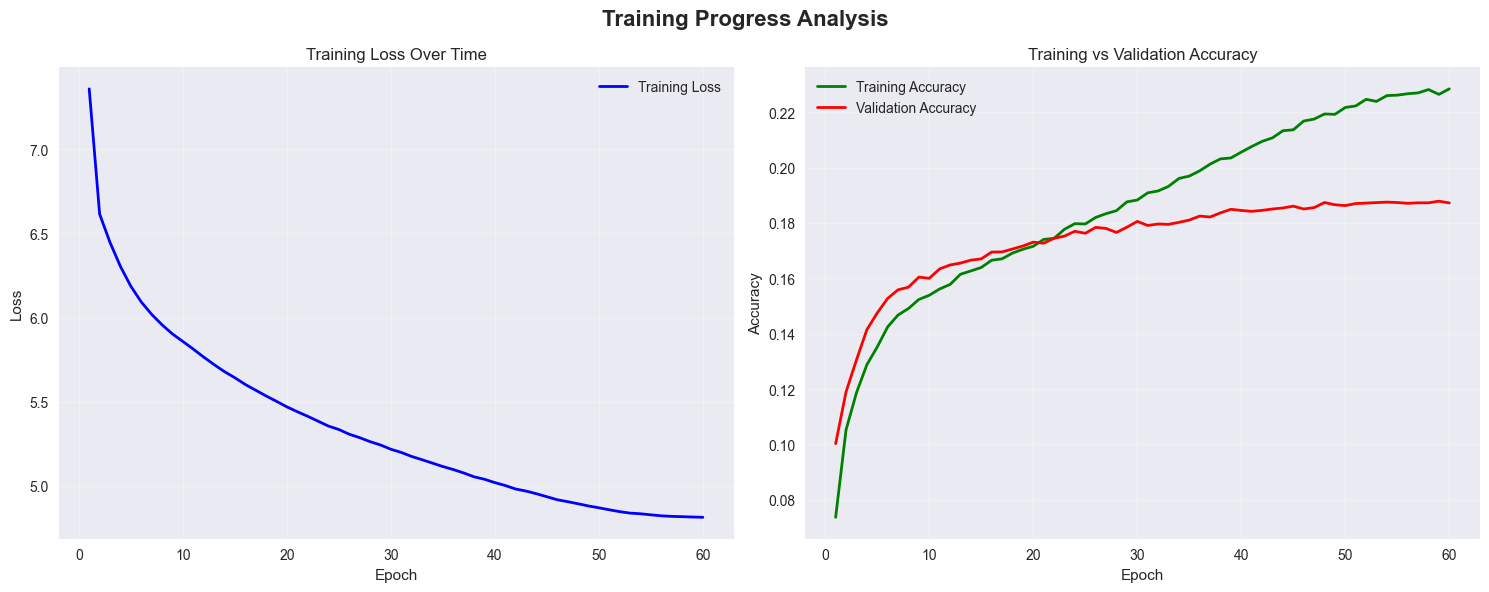


TESTING WINDOW SIZE 5

Context (6 words): 'the cat sat on the mat'
Predictions: .(0.125), is(0.061), ,(0.061), of(0.040), or(0.030)

Context (6 words): 'i like to eat pizza sometimes'
Predictions: .(0.276), ,(0.065), to(0.051), and(0.042), in(0.029)

Context (6 words): 'she went to the store today'
Predictions: .(0.295), ,(0.114), where(0.035), of(0.026), to(0.026)

Context (6 words): 'artificial intelligence is becoming very popular'
Predictions: in(0.331), .(0.124), and(0.082), with(0.067), for(0.059)

Context (6 words): 'students should study hard for exams'
Predictions: .(0.384), ,(0.074), and(0.045), in(0.037), to(0.033)

EXPERIMENTING WITH WINDOW SIZE: 7
Using device: cpu
Context window size: 7
Feature vector size: 100x1 (exponential weighted average only)
Loaded 13281 unique sentences
BPE tokenizer trained with 10000 tokens


Loading GloVe: 400000it [00:08, 47098.80it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:41<00:00, 98.81it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)
Subword approximation coverage: 1295/10000 tokens (13.0%)
Total coverage: 97.7%
Top 10 uncovered frequent tokens: [('babwe', 0), ('ώ', 0), ('cloc', 0), ('industr', 0), ('therlands', 0), ('diame', 0), ('shevik', 0), ('enant', 0), ('ulary', 0), ("',", 0)]


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 32110.57it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:07<00:00, 27261.90it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10960
After filtering: 189834 samples, 5310 classes
Epoch 0: Train Loss: 7.3967, Train Acc: 0.070, Top-1: 0.102, Top-5: 0.242, Top-10: 0.310
Epoch 10: Train Loss: 5.8184, Train Acc: 0.155, Top-1: 0.161, Top-5: 0.332, Top-10: 0.407
Epoch 20: Train Loss: 5.4416, Train Acc: 0.173, Top-1: 0.171, Top-5: 0.345, Top-10: 0.421
Epoch 30: Train Loss: 5.1970, Train Acc: 0.189, Top-1: 0.176, Top-5: 0.350, Top-10: 0.427
Epoch 40: Train Loss: 4.9987, Train Acc: 0.207, Top-1: 0.182, Top-5: 0.354, Top-10: 0.430
Epoch 50: Train Loss: 4.8593, Train Acc: 0.222, Top-1: 0.183, Top-5: 0.355, Top-10: 0.430
Epoch 59: Train Loss: 4.8143, Train Acc: 0.226, Top-1: 0.184, Top-5: 0.356, Top-10: 0.430

Best metrics:
Top-1 accuracy: 18.5%
Top-5 accuracy: 35.6%
Top-10 accuracy: 43.1%


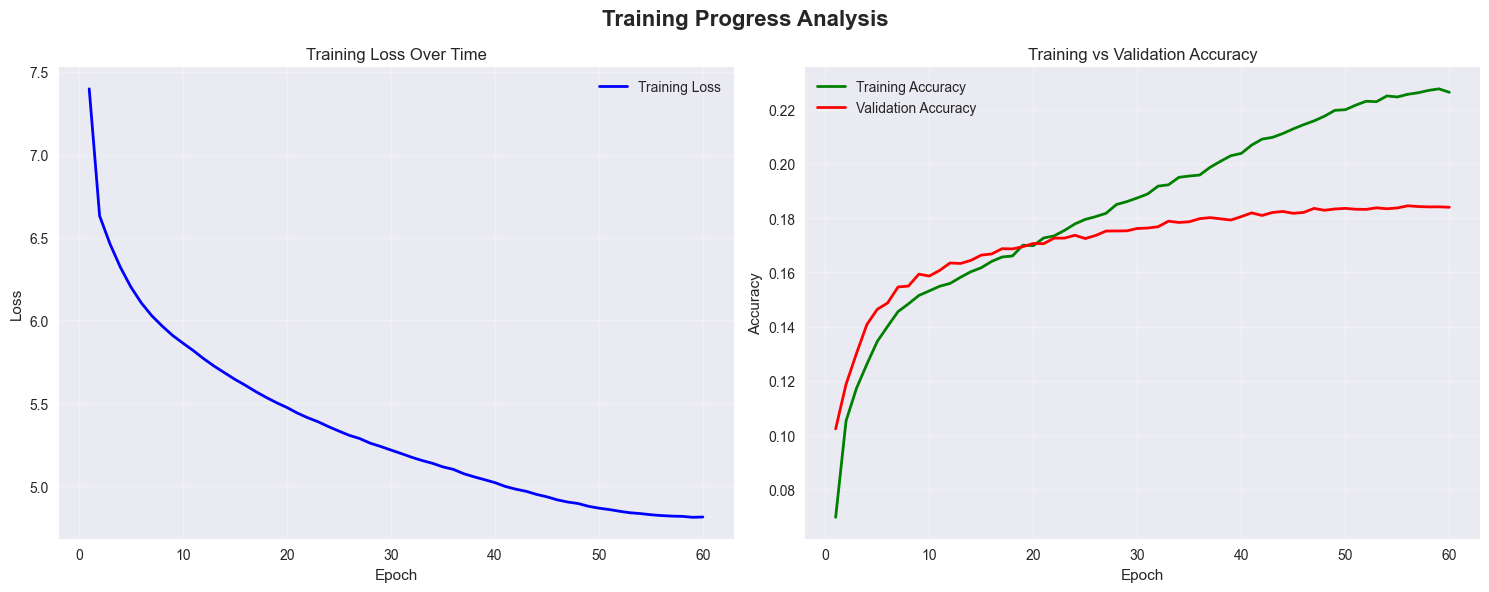


TESTING WINDOW SIZE 7

Context (10 words): 'the quick brown fox jumped over the lazy dog yesterday'
Predictions: .(0.156), ,(0.110), is(0.106), in(0.034), of(0.025)

Context (12 words): 'machine learning algorithms are becoming increasingly sophisticated and powerful in many applications'
Predictions: .(0.141), of(0.083), ,(0.083), ations(0.038), software(0.022)

Context (12 words): 'after a long day at work she decided to relax and watch'
Predictions: .(0.123), to(0.092), and(0.051), the(0.049), ,(0.035)

Context (12 words): 'the weather forecast predicted heavy rain and strong winds for the entire'
Predictions: earth(0.067), of(0.041), speed(0.034), surface(0.030), nose(0.029)

Context (12 words): 'artificial intelligence will revolutionize the way we think about technology and automation'
Predictions: ,(0.059), is(0.048), es(0.023), in(0.022), that(0.022)

EXPERIMENTING WITH WINDOW SIZE: 10
Using device: cpu
Context window size: 10
Feature vector size: 100x1 (exponential weighted a

Loading GloVe: 400000it [00:08, 49353.64it/s]


Loaded 400000 GloVe vectors


Mapping embeddings: 100%|██████████| 10000/10000 [01:44<00:00, 95.26it/s]


Direct GloVe coverage: 8479/10000 tokens (84.8%)
Subword approximation coverage: 1295/10000 tokens (13.0%)
Total coverage: 97.7%
Top 10 uncovered frequent tokens: [('aneous', 0), ('zania', 0), ('multip', 0), ('leag', 0), ('ingredi', 0), ('execut', 0), ('fallop', 0), ('suppli', 0), ('rect', 0), ('abbre', 0)]


Tokenizing: 100%|██████████| 13281/13281 [00:00<00:00, 32290.86it/s]


Valid tokens: 325334/325334


Creating samples: 100%|██████████| 200000/200000 [00:07<00:00, 27071.23it/s]


Created 200000 samples with 100 features (should be 100)
Classes: 9101, Min samples: 1, Max: 10960
After filtering: 189834 samples, 5310 classes
Epoch 0: Train Loss: 7.3963, Train Acc: 0.071, Top-1: 0.105, Top-5: 0.243, Top-10: 0.313
Epoch 10: Train Loss: 5.8161, Train Acc: 0.153, Top-1: 0.161, Top-5: 0.332, Top-10: 0.409
Epoch 20: Train Loss: 5.4457, Train Acc: 0.171, Top-1: 0.170, Top-5: 0.345, Top-10: 0.421
Epoch 30: Train Loss: 5.2046, Train Acc: 0.188, Top-1: 0.176, Top-5: 0.351, Top-10: 0.428
Epoch 40: Train Loss: 5.0065, Train Acc: 0.205, Top-1: 0.181, Top-5: 0.355, Top-10: 0.431
Epoch 50: Train Loss: 4.8588, Train Acc: 0.221, Top-1: 0.182, Top-5: 0.355, Top-10: 0.433
Epoch 59: Train Loss: 4.8144, Train Acc: 0.226, Top-1: 0.182, Top-5: 0.355, Top-10: 0.432

Best metrics:
Top-1 accuracy: 18.3%
Top-5 accuracy: 35.5%
Top-10 accuracy: 43.2%


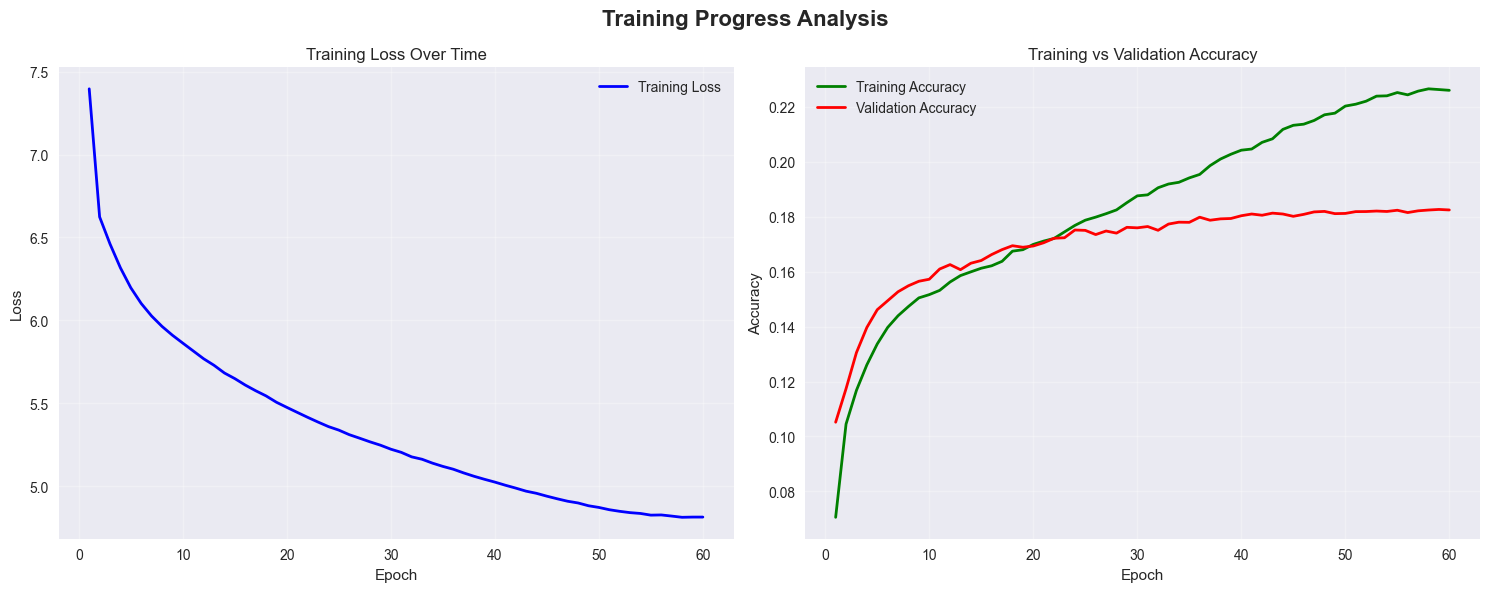


TESTING WINDOW SIZE 10

Context (20 words): 'the research team at the university has been working on developing new machine learning algorithms for natural language processing applications'
Predictions: .(0.377), ,(0.114), and(0.039), that(0.035), for(0.028)

Context (22 words): 'during the global pandemic many companies had to quickly adapt their business models and transition to remote work environments for employee safety'
Predictions: .(0.111), ,(0.057), is(0.037), to(0.024), and(0.023)

Context (22 words): 'the professor explained that understanding the mathematical foundations of artificial intelligence requires knowledge of linear algebra statistics and calculus among other subjects'
Predictions: .(0.221), ,(0.157), are(0.100), that(0.066), and(0.055)

Context (22 words): 'climate change researchers are using advanced computer models and satellite data to better understand and predict future environmental changes across different regions'
Predictions: .(0.455), ,(0.082), :(0.07

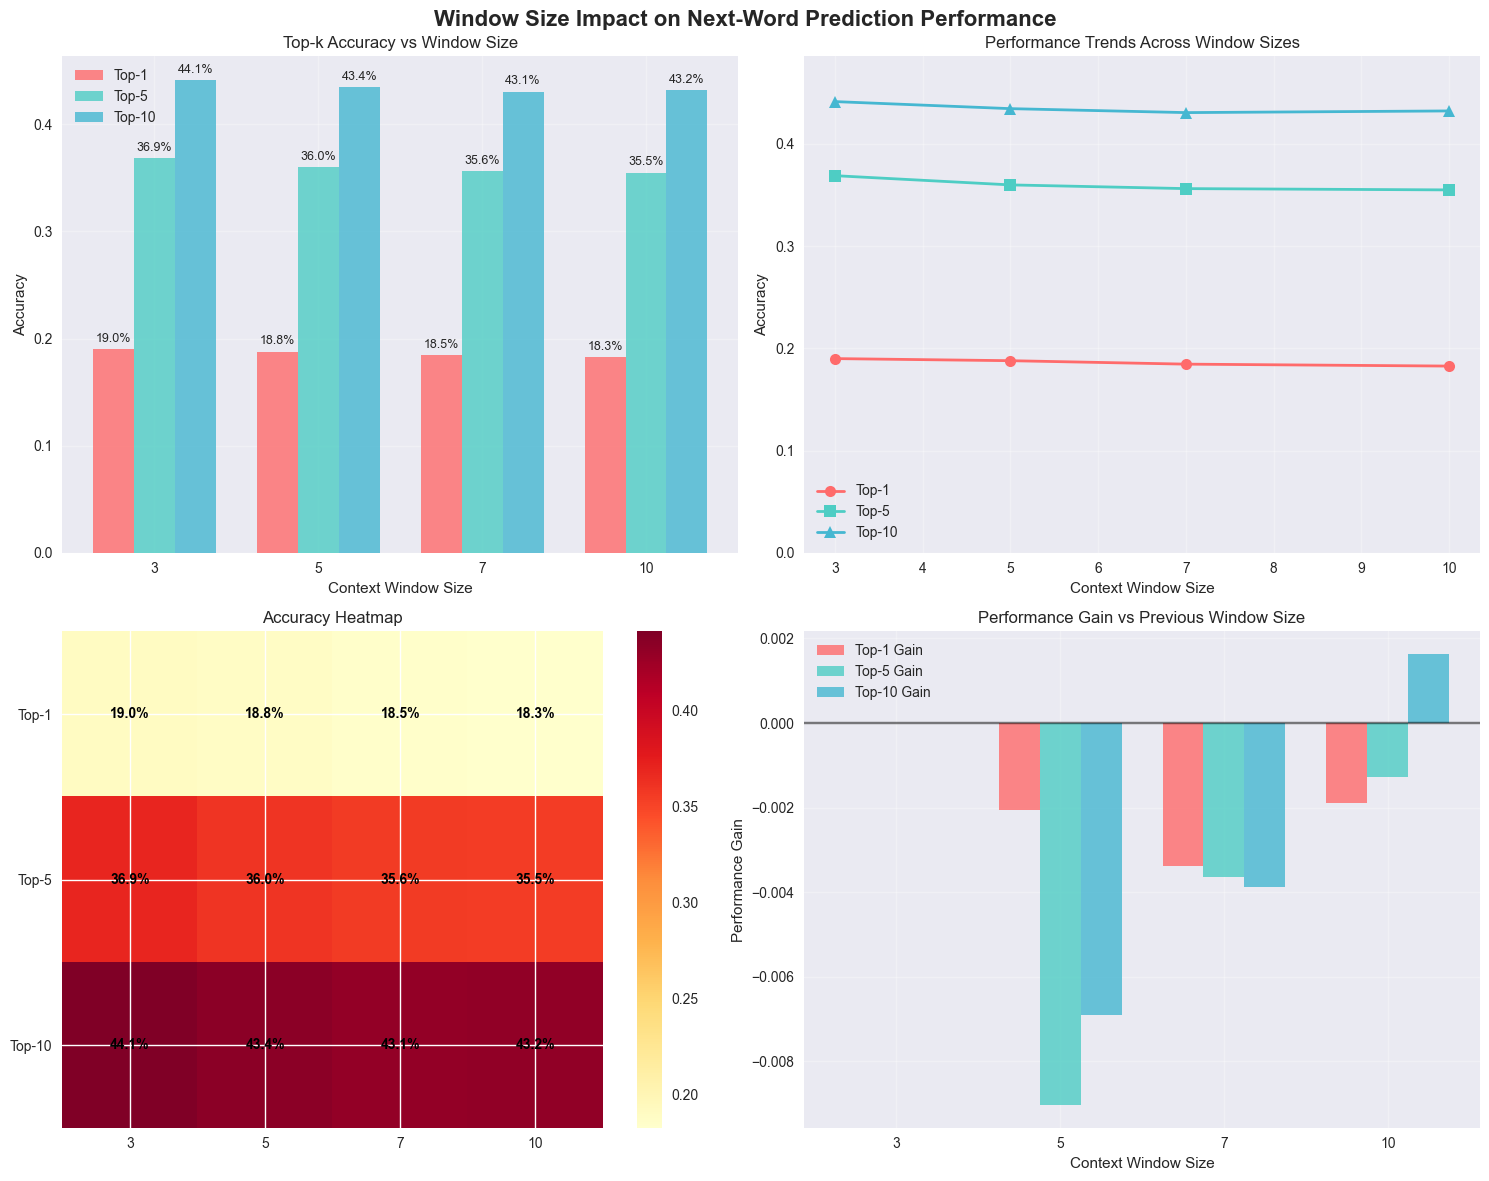

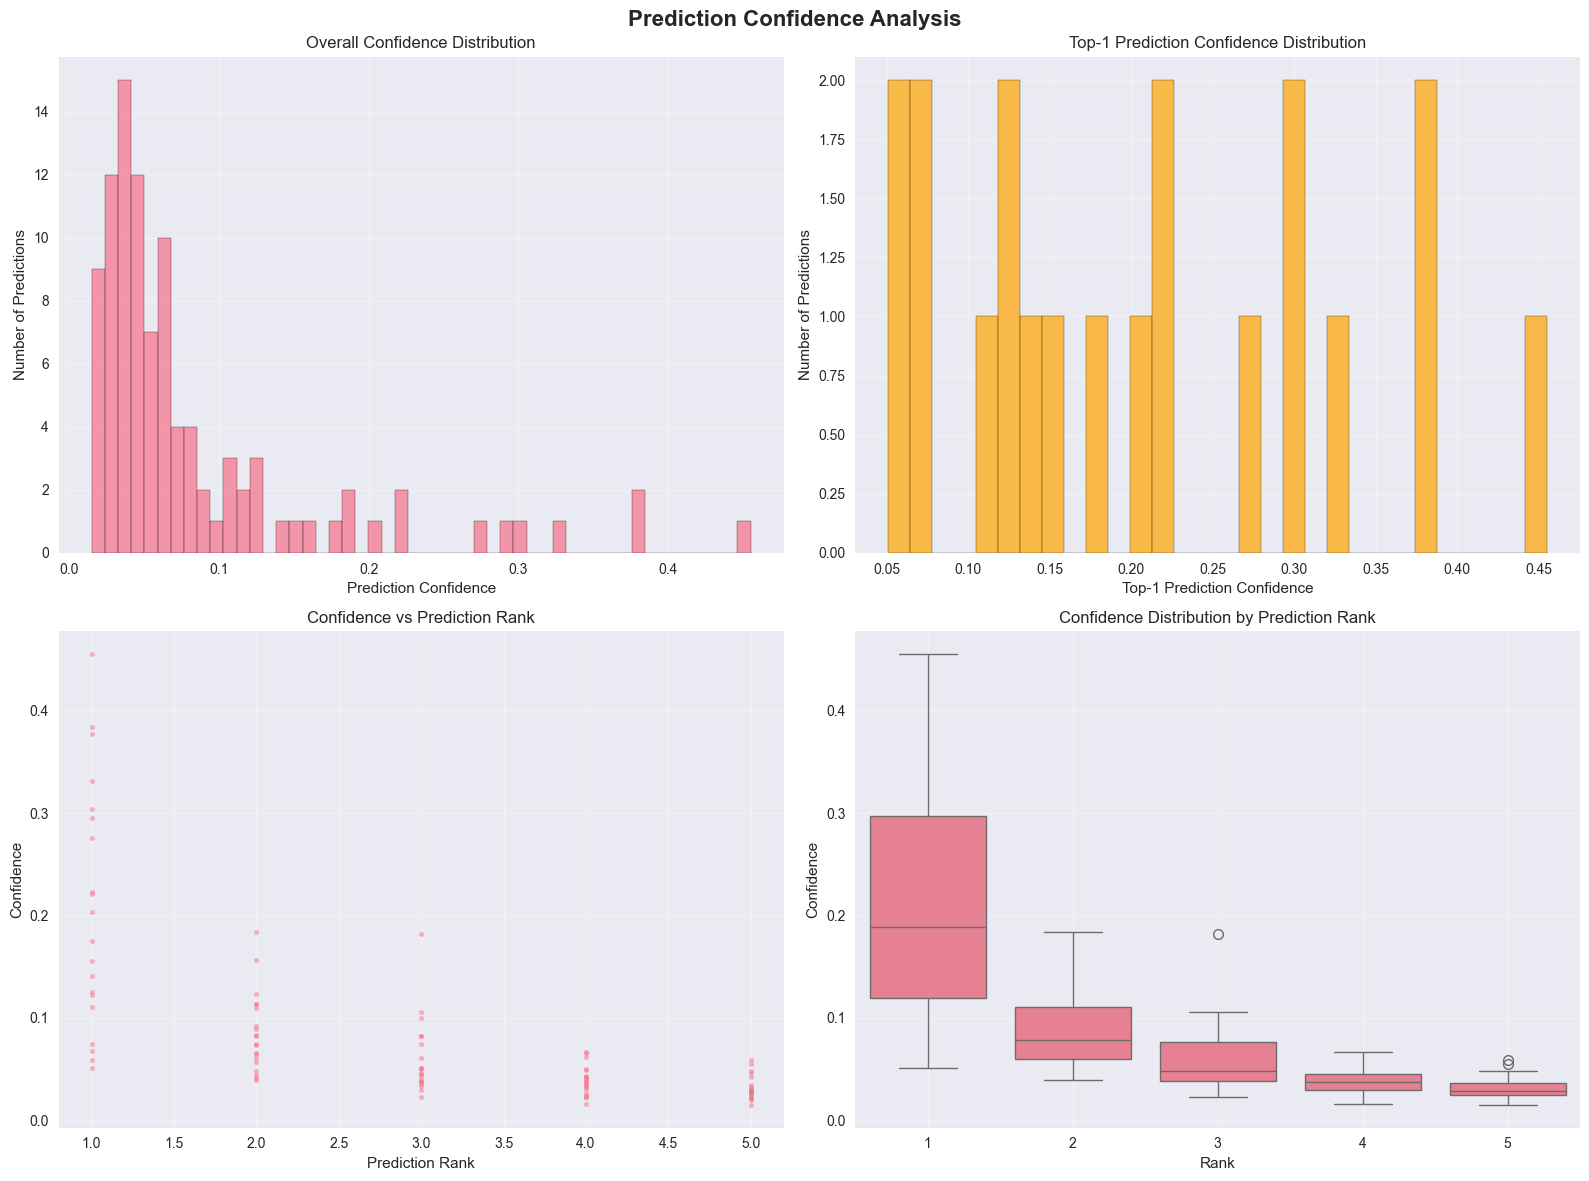


WINDOW SIZE COMPARISON RESULTS
Window   Top-1      Top-5      Top-10    
------------------------------------------


ValueError: Invalid format specifier '.1%:<10' for object of type 'float'

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import pickle
import gc
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import os
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for research paper quality plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

DATASET_PATH = r"D:\Heisenber\simplewiki.txt"
GLOVE_PATH = r"C:\Users\Asus\Desktop\Heisenber\glove.6B.100d.txt"
EMB_DIM = 100
MAX_SAMPLES = 200_000
VOCAB_SIZE = 10000
WINDOW_SIZE = 5 
MODEL_SAVE_PATH = "nextword_model.pkl"
BPE_TOKENIZER_PATH = "bpe_tokenizer.json"

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)
        smoothed_targets = targets * (1 - self.label_smoothing) + self.label_smoothing / num_classes
        
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class NextWordDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def calculate_topk_accuracy(y_true, y_pred_probs, k_values=[1, 5, 10]):
    accuracies = {}
    
    for k in k_values:
        top_k_preds = np.argsort(y_pred_probs, axis=1)[:, -k:]
        
        correct = 0
        for i, true_label in enumerate(y_true):
            if true_label in top_k_preds[i]:
                correct += 1
        
        accuracies[f'top_{k}'] = correct / len(y_true)
    
    return accuracies

class ResearchVisualizer:
    def __init__(self, save_path="research_plots/"):
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)
        
    def plot_window_size_comparison(self, results, save_name="window_size_comparison.png"):
        """Create comprehensive window size comparison plots"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Window Size Impact on Next-Word Prediction Performance', fontsize=16, fontweight='bold')
        
        window_sizes = list(results.keys())
        top1_scores = [results[w]['top_1'] for w in window_sizes]
        top5_scores = [results[w]['top_5'] for w in window_sizes]
        top10_scores = [results[w]['top_10'] for w in window_sizes]
        
        # 1. Bar plot comparison
        x = np.arange(len(window_sizes))
        width = 0.25
        
        bars1 = ax1.bar(x - width, top1_scores, width, label='Top-1', alpha=0.8, color='#FF6B6B')
        bars2 = ax1.bar(x, top5_scores, width, label='Top-5', alpha=0.8, color='#4ECDC4')
        bars3 = ax1.bar(x + width, top10_scores, width, label='Top-10', alpha=0.8, color='#45B7D1')
        
        ax1.set_xlabel('Context Window Size')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Top-k Accuracy vs Window Size')
        ax1.set_xticks(x)
        ax1.set_xticklabels(window_sizes)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax1.annotate(f'{height:.1%}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)
        
        # 2. Line plot showing trends
        ax2.plot(window_sizes, top1_scores, 'o-', linewidth=2, markersize=8, label='Top-1', color='#FF6B6B')
        ax2.plot(window_sizes, top5_scores, 's-', linewidth=2, markersize=8, label='Top-5', color='#4ECDC4')
        ax2.plot(window_sizes, top10_scores, '^-', linewidth=2, markersize=8, label='Top-10', color='#45B7D1')
        ax2.set_xlabel('Context Window Size')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Performance Trends Across Window Sizes')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, max(max(top1_scores), max(top5_scores), max(top10_scores)) * 1.1)
        
        # 3. Improvement heatmap
        metrics_matrix = np.array([top1_scores, top5_scores, top10_scores])
        im = ax3.imshow(metrics_matrix, cmap='YlOrRd', aspect='auto')
        ax3.set_xticks(range(len(window_sizes)))
        ax3.set_xticklabels(window_sizes)
        ax3.set_yticks(range(3))
        ax3.set_yticklabels(['Top-1', 'Top-5', 'Top-10'])
        ax3.set_title('Accuracy Heatmap')
        
        # Add text annotations
        for i in range(3):
            for j in range(len(window_sizes)):
                text = ax3.text(j, i, f'{metrics_matrix[i, j]:.1%}',
                              ha="center", va="center", color="black", fontweight='bold')
        
        plt.colorbar(im, ax=ax3)
        
        # 4. Performance gain analysis
        if len(window_sizes) > 1:
            gains_top1 = [0] + [(top1_scores[i] - top1_scores[i-1]) for i in range(1, len(top1_scores))]
            gains_top5 = [0] + [(top5_scores[i] - top5_scores[i-1]) for i in range(1, len(top5_scores))]
            gains_top10 = [0] + [(top10_scores[i] - top10_scores[i-1]) for i in range(1, len(top10_scores))]
            
            ax4.bar(x - width, gains_top1, width, label='Top-1 Gain', alpha=0.8, color='#FF6B6B')
            ax4.bar(x, gains_top5, width, label='Top-5 Gain', alpha=0.8, color='#4ECDC4')
            ax4.bar(x + width, gains_top10, width, label='Top-10 Gain', alpha=0.8, color='#45B7D1')
            
            ax4.set_xlabel('Context Window Size')
            ax4.set_ylabel('Performance Gain')
            ax4.set_title('Performance Gain vs Previous Window Size')
            ax4.set_xticks(x)
            ax4.set_xticklabels(window_sizes)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_path, save_name), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_training_metrics(self, train_losses, train_accs, val_accs, save_name="training_metrics.png"):
        """Plot training progress"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Training Progress Analysis', fontsize=16, fontweight='bold')
        
        epochs = range(1, len(train_losses) + 1)
        
        # Loss plot
        ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy plot
        ax2.plot(epochs, train_accs, 'g-', linewidth=2, label='Training Accuracy')
        ax2.plot(epochs, val_accs, 'r-', linewidth=2, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training vs Validation Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_path, save_name), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_embedding_analysis(self, embeddings, tokens, sample_size=1000, save_name="embedding_analysis.png"):
        """Analyze and visualize embeddings"""
        # Sample embeddings for visualization
        indices = np.random.choice(len(embeddings), min(sample_size, len(embeddings)), replace=False)
        sample_embeddings = embeddings[indices]
        sample_tokens = [tokens[i] for i in indices]
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Embedding Space Analysis', fontsize=16, fontweight='bold')
        
        # 1. PCA visualization
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(sample_embeddings)
        
        scatter = ax1.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=20)
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        ax1.set_title('PCA of Embedding Space')
        ax1.grid(True, alpha=0.3)
        
        # 2. t-SNE visualization (if sample size allows)
        if len(sample_embeddings) > 50:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_embeddings)-1))
            tsne_result = tsne.fit_transform(sample_embeddings)
            
            scatter2 = ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6, s=20)
            ax2.set_xlabel('t-SNE 1')
            ax2.set_ylabel('t-SNE 2')
            ax2.set_title('t-SNE of Embedding Space')
            ax2.grid(True, alpha=0.3)
        
        # 3. Embedding dimension variance
        dim_variance = np.var(sample_embeddings, axis=0)
        ax3.hist(dim_variance, bins=30, alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Variance')
        ax3.set_ylabel('Number of Dimensions')
        ax3.set_title('Variance Distribution Across Embedding Dimensions')
        ax3.grid(True, alpha=0.3)
        
        # 4. Embedding magnitude distribution
        magnitudes = np.linalg.norm(sample_embeddings, axis=1)
        ax4.hist(magnitudes, bins=30, alpha=0.7, edgecolor='black')
        ax4.set_xlabel('L2 Norm')
        ax4.set_ylabel('Number of Embeddings')
        ax4.set_title('Distribution of Embedding Magnitudes')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_path, save_name), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_token_frequency_analysis(self, token_freq, save_name="token_frequency.png"):
        """Analyze token frequency distribution"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Token Frequency Analysis', fontsize=16, fontweight='bold')
        
        frequencies = list(token_freq.values())
        tokens = list(token_freq.keys())
        
        # 1. Frequency distribution
        ax1.hist(frequencies, bins=50, alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Token Frequency')
        ax1.set_ylabel('Number of Tokens')
        ax1.set_title('Token Frequency Distribution')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        # 2. Top tokens
        top_tokens = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)[:20]
        tokens_top, freqs_top = zip(*top_tokens)
        
        ax2.barh(range(len(tokens_top)), freqs_top)
        ax2.set_yticks(range(len(tokens_top)))
        ax2.set_yticklabels(tokens_top)
        ax2.set_xlabel('Frequency')
        ax2.set_title('Top 20 Most Frequent Tokens')
        ax2.grid(True, alpha=0.3)
        
        # 3. Zipf's law analysis
        sorted_freqs = sorted(frequencies, reverse=True)
        ranks = range(1, len(sorted_freqs) + 1)
        
        ax3.loglog(ranks, sorted_freqs, 'b-', alpha=0.7)
        ax3.set_xlabel('Rank')
        ax3.set_ylabel('Frequency')
        ax3.set_title("Zipf's Law: Frequency vs Rank")
        ax3.grid(True, alpha=0.3)
        
        # 4. Cumulative frequency
        cumulative_freq = np.cumsum(sorted_freqs) / np.sum(sorted_freqs)
        ax4.plot(ranks, cumulative_freq, 'r-', linewidth=2)
        ax4.set_xlabel('Token Rank')
        ax4.set_ylabel('Cumulative Frequency Proportion')
        ax4.set_title('Cumulative Token Frequency Distribution')
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='50%')
        ax4.axhline(y=0.8, color='black', linestyle='--', alpha=0.5, label='80%')
        ax4.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_path, save_name), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_prediction_confidence_analysis(self, predictions_data, save_name="prediction_confidence.png"):
        """Analyze prediction confidence patterns"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')
        
        all_confidences = []
        top1_confidences = []
        
        for preds in predictions_data:
            if preds:
                confidences = [conf for _, conf, _ in preds]
                all_confidences.extend(confidences)
                top1_confidences.append(confidences[0])
        
        # 1. Confidence distribution
        ax1.hist(all_confidences, bins=50, alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Prediction Confidence')
        ax1.set_ylabel('Number of Predictions')
        ax1.set_title('Overall Confidence Distribution')
        ax1.grid(True, alpha=0.3)
        
        # 2. Top-1 confidence distribution
        ax2.hist(top1_confidences, bins=30, alpha=0.7, edgecolor='black', color='orange')
        ax2.set_xlabel('Top-1 Prediction Confidence')
        ax2.set_ylabel('Number of Predictions')
        ax2.set_title('Top-1 Prediction Confidence Distribution')
        ax2.grid(True, alpha=0.3)
        
        # 3. Confidence vs rank
        ranks = []
        confidences = []
        for preds in predictions_data:
            if preds:
                for i, (_, conf, _) in enumerate(preds):
                    ranks.append(i + 1)
                    confidences.append(conf)
        
        ax3.scatter(ranks, confidences, alpha=0.5, s=10)
        ax3.set_xlabel('Prediction Rank')
        ax3.set_ylabel('Confidence')
        ax3.set_title('Confidence vs Prediction Rank')
        ax3.grid(True, alpha=0.3)
        
        # 4. Confidence statistics by rank
        rank_stats = defaultdict(list)
        for preds in predictions_data:
            if preds:
                for i, (_, conf, _) in enumerate(preds):
                    rank_stats[i + 1].append(conf)
        
        ranks_for_box = []
        conf_for_box = []
        for rank in sorted(rank_stats.keys()):
            ranks_for_box.extend([rank] * len(rank_stats[rank]))
            conf_for_box.extend(rank_stats[rank])
        
        df_box = pd.DataFrame({'Rank': ranks_for_box, 'Confidence': conf_for_box})
        sns.boxplot(data=df_box, x='Rank', y='Confidence', ax=ax4)
        ax4.set_title('Confidence Distribution by Prediction Rank')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_path, save_name), dpi=300, bbox_inches='tight')
        plt.show()

class EnhancedNextWordPredictor:
    def __init__(self, vocab_size=10000, window_size=5, emb_dim=100):
        self.vocab_size = vocab_size
        self.window_size = window_size
        self.emb_dim = emb_dim
        self.tokenizer = None
        self.token_to_idx = None
        self.idx_to_token = None
        self.token_freq = None
        self.glove_embeddings = None
        self.glove_dict = None  
        self.model = None
        self.scaler = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.visualizer = ResearchVisualizer()
        self.training_history = {'train_losses': [], 'train_accs': [], 'val_accs': []}
        print(f"Using device: {self.device}")
        print(f"Context window size: {self.window_size}")
        print(f"Feature vector size: {self.emb_dim}x1 (exponential weighted average only)")
        
    def load_dataset(self, dataset_path, max_lines=None):
        try:
            sentences = []
            with open(dataset_path, 'r', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if max_lines and i >= max_lines:
                        break
                    
                    line = line.strip()
                    if not line:
                        continue
                    
                    # Clean text
                    line = re.sub(r'[^\w\s.,!?;:\'"-]', ' ', line)
                    line = re.sub(r'\s+', ' ', line)
                    line = line.lower()
                    
                    # Filter by length
                    words = line.split()
                    if 6 <= len(words) <= 30: 
                        sentences.append(line)
            
            # Remove duplicates and sort
            sentences = list(set(sentences))
            sentences.sort(key=lambda x: (len(x.split()), x))
            
            print(f"Loaded {len(sentences)} unique sentences")
            return sentences
            
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None
    
    def train_bpe_tokenizer(self, sentences):
        self.tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
        self.tokenizer.pre_tokenizer = Whitespace()

        trainer = BpeTrainer(
            vocab_size=self.vocab_size,
            min_frequency=3,
            special_tokens=["<PAD>", "<UNK>", "<START>", "<END>"],
            show_progress=True
        )

        self.tokenizer.train_from_iterator(sentences, trainer)
        self.tokenizer.save(BPE_TOKENIZER_PATH)

        vocab = self.tokenizer.get_vocab()
        self.token_to_idx = vocab
        self.idx_to_token = {v: k for k, v in vocab.items()}
        
        print(f"BPE tokenizer trained with {len(vocab)} tokens")
        return True

    def tokenize_texts(self, sentences):
        token_list = []
        
        for sentence in tqdm(sentences, desc="Tokenizing"):
            tokens = self.tokenizer.encode(sentence).tokens
            token_list.extend(tokens)
        
        # Store token frequencies for confidence scoring
        self.token_freq = dict(Counter(token_list))
        
        return token_list

    def get_subword_embedding(self, token):
        """Enhanced subword embedding with detailed analysis"""
        if not self.glove_dict:
            return np.random.normal(0, 0.03, self.emb_dim)

        # Direct match
        if token in self.glove_dict:
            return self.glove_dict[token]

        # Case insensitive match
        if token.lower() in self.glove_dict:
            return self.glove_dict[token.lower()]

        # Handle BPE prefix (Ġ indicates word start in some tokenizers)
        if token.startswith('Ġ'): 
            clean_token = token[1:]
            if clean_token in self.glove_dict:
                return self.glove_dict[clean_token]
            if clean_token.lower() in self.glove_dict:
                return self.glove_dict[clean_token.lower()]

        # Suffix matching for subwords
        if len(token) >= 3:
            candidates = [word for word in self.glove_dict.keys() 
                         if word.endswith(token) and len(word) > len(token)]
            if candidates:
                return self.glove_dict[candidates[0]]

        # Fuzzy matching for subwords
        if len(token) >= 2:
            similar_words = [word for word in self.glove_dict.keys() 
                           if len(word) >= 2 and (
                               word.startswith(token[:2]) or 
                               word.endswith(token[-2:])
                           )][:5]
            
            if similar_words:
                embeddings = [self.glove_dict[word] for word in similar_words]
                return np.mean(embeddings, axis=0)

        # Random embedding for unknown tokens
        return np.random.normal(0, 0.03, self.emb_dim)

    def load_glove_embeddings(self):
        if not os.path.exists(GLOVE_PATH):
            print(f"GloVe file not found. Using random embeddings.")
            self.glove_embeddings = np.random.normal(0, 0.1, (len(self.token_to_idx), self.emb_dim))
            return
        
        self.glove_dict = {}
        
        try:
            with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
                for line in tqdm(f, desc="Loading GloVe"):
                    parts = line.strip().split()
                    if len(parts) == self.emb_dim + 1:
                        word = parts[0]
                        vector = np.array([float(x) for x in parts[1:]])
                        self.glove_dict[word] = vector
                        
        except Exception as e:
            print(f"Error loading GloVe: {e}")
            self.glove_embeddings = np.random.normal(0, 0.1, (len(self.token_to_idx), self.emb_dim))
            return
        
        print(f"Loaded {len(self.glove_dict)} GloVe vectors")
        
        # Initialize embeddings matrix
        self.glove_embeddings = np.random.normal(0, 0.03, (len(self.token_to_idx), self.emb_dim))
        
        # Map tokens to embeddings using enhanced subword handling
        found_count = 0
        subword_count = 0
        
        for token, idx in tqdm(self.token_to_idx.items(), desc="Mapping embeddings"):
            embedding = self.get_subword_embedding(token)
            self.glove_embeddings[idx] = embedding
            
            # Count coverage types
            if token in self.glove_dict or token.lower() in self.glove_dict:
                found_count += 1
            elif len(token) >= 2:  # Subword approximation
                subword_count += 1
        
        direct_coverage = found_count / len(self.token_to_idx) * 100
        subword_coverage = subword_count / len(self.token_to_idx) * 100
        total_coverage = (found_count + subword_count) / len(self.token_to_idx) * 100
        
        print(f"Direct GloVe coverage: {found_count}/{len(self.token_to_idx)} tokens ({direct_coverage:.1f}%)")
        print(f"Subword approximation coverage: {subword_count}/{len(self.token_to_idx)} tokens ({subword_coverage:.1f}%)")
        print(f"Total coverage: {total_coverage:.1f}%")
        
        # Analyze token frequency for uncovered tokens
        uncovered_tokens = []
        for token, idx in self.token_to_idx.items():
            if token not in self.glove_dict and token.lower() not in self.glove_dict:
                freq = self.token_freq.get(token, 0) if self.token_freq else 0
                uncovered_tokens.append((token, freq))
        
        uncovered_tokens.sort(key=lambda x: x[1], reverse=True)
        print(f"Top 10 uncovered frequent tokens: {uncovered_tokens[:10]}")
     
    def create_exponential_weighted_features(self, context_tokens):
        """Create ONLY exponential weighted average features (100x1 vector)"""
        if len(context_tokens) != self.window_size:
            return None

        context_indices = [self.token_to_idx.get(token, self.token_to_idx['<UNK>']) 
                          for token in context_tokens]
        context_embeddings = self.glove_embeddings[context_indices]
        
        # Exponential weighting - more recent words get higher weights
        positions = np.arange(self.window_size)
        alpha = 0.3 
        exp_weights = np.exp(-alpha * (self.window_size - 1 - positions))
        exp_weights = exp_weights / np.sum(exp_weights) 
        
        # Only exponential weighted average (100x1 vector)
        exponential_weighted_avg = np.average(context_embeddings, weights=exp_weights, axis=0)
        
        return exponential_weighted_avg
    
    def create_training_samples(self, tokens):
        X_features = []
        y_labels = []

        valid_tokens = [token for token in tokens if token in self.token_to_idx]
        print(f"Valid tokens: {len(valid_tokens)}/{len(tokens)}")

        sample_indices = list(range(self.window_size, min(len(valid_tokens), MAX_SAMPLES + self.window_size)))
        
        for i in tqdm(sample_indices, desc="Creating samples"):
            if i >= len(valid_tokens):
                break
                
            target_token = valid_tokens[i]
            # Context from i-window_size to i-1 (for i-th target)
            context_tokens = valid_tokens[i - self.window_size:i]
            
            features = self.create_exponential_weighted_features(context_tokens)
            if features is None:
                continue
            
            X_features.append(features)
            y_labels.append(self.token_to_idx[target_token])
        
        X = np.array(X_features, dtype=np.float32)
        y = np.array(y_labels)
        
        print(f"Created {len(X)} samples with {X.shape[1]} features (should be {self.emb_dim})")
        assert X.shape[1] == self.emb_dim, f"Expected {self.emb_dim} features, got {X.shape[1]}"
        
        # Class distribution analysis
        unique_classes, counts = np.unique(y, return_counts=True)
        print(f"Classes: {len(unique_classes)}, Min samples: {counts.min()}, Max: {counts.max()}")
        
        return X, y
    
    def train_model(self, X, y):
        # Filter classes with minimum samples
        class_counts = Counter(y)
        min_samples = 5
        mask = np.array([class_counts[label] >= min_samples for label in y])
        X_filtered = X[mask]
        y_filtered = y[mask]
        
        print(f"After filtering: {len(X_filtered)} samples, {len(np.unique(y_filtered))} classes")

        unique_labels = np.unique(y_filtered)
        label_map = {old: new for new, old in enumerate(unique_labels)}
        y_mapped = np.array([label_map[label] for label in y_filtered])
        
        # Data split
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42
        )
        
        # Scaling
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Datasets
        train_dataset = NextWordDataset(X_train_scaled, y_train)
        test_dataset = NextWordDataset(X_test_scaled, y_test)
        
        batch_size = min(256, len(X_train_scaled) // 10)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        input_size = X_train_scaled.shape[1] 
        num_classes = len(unique_labels)
        
        self.model = nn.Sequential(
            # First hidden layer
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),
            
            # Second hidden layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            
            # Third hidden layer
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(256),
            
            # Fourth hidden layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Output layer
            nn.Linear(128, num_classes)
        ).to(self.device)

        self.label_map = label_map
        self.reverse_label_map = {v: k for k, v in label_map.items()}

        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # More epochs for better accuracy
        num_epochs = 60
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=0.003, epochs=num_epochs, steps_per_epoch=len(train_loader)
        )
        
        best_test_acc = 0
        best_metrics = {}
        
        # Initialize training history
        self.training_history = {'train_losses': [], 'train_accs': [], 'val_accs': []}
        
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()

            # Validation phase
            self.model.eval()
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    outputs = self.model(batch_X)
                    probs = torch.softmax(outputs, dim=1)
                    
                    all_preds.append(probs.cpu().numpy())
                    all_labels.extend(batch_y.cpu().numpy())
        
            all_preds = np.vstack(all_preds)
            all_labels = np.array(all_labels)
            metrics = calculate_topk_accuracy(all_labels, all_preds, k_values=[1, 5, 10])
            
            train_acc = train_correct / train_total
            train_loss_avg = train_loss / len(train_loader)
            
            # Store training history
            self.training_history['train_losses'].append(train_loss_avg)
            self.training_history['train_accs'].append(train_acc)
            self.training_history['val_accs'].append(metrics['top_1'])
            
            if metrics['top_1'] > best_test_acc:
                best_test_acc = metrics['top_1']
                best_metrics = metrics.copy()
                torch.save(self.model.state_dict(), 'best_model.pth')
            
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f'Epoch {epoch}: Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.3f}, '
                      f'Top-1: {metrics["top_1"]:.3f}, '
                      f'Top-5: {metrics["top_5"]:.3f}, '
                      f'Top-10: {metrics["top_10"]:.3f}')
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))
        print(f"\nBest metrics:")
        print(f"Top-1 accuracy: {best_metrics['top_1']:.1%}")
        print(f"Top-5 accuracy: {best_metrics['top_5']:.1%}")
        print(f"Top-10 accuracy: {best_metrics['top_10']:.1%}")
        
        # Plot training metrics
        self.visualizer.plot_training_metrics(
            self.training_history['train_losses'],
            self.training_history['train_accs'],
            self.training_history['val_accs']
        )
        
        return best_metrics
    
    def predict_next_word(self, text, top_k=10):
        if self.model is None:
            raise ValueError("Model not trained!")

        tokens = self.tokenizer.encode(text.lower()).tokens
        
        if len(tokens) < self.window_size:
            padding_needed = self.window_size - len(tokens)
            if tokens:
                pad_token = "<PAD>" if "<PAD>" in self.token_to_idx else tokens[-1]
                tokens = [pad_token] * padding_needed + tokens
            else:
                return None

        context_tokens = tokens[-self.window_size:]

        features = self.create_exponential_weighted_features(context_tokens)
        if features is None:
            return None
        
        features_scaled = self.scaler.transform([features])
    
        self.model.eval()
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features_scaled).to(self.device)
            outputs = self.model(features_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

        top_indices = np.argsort(probs)[-top_k:][::-1]
        predictions = []
        
        for idx in top_indices:
            if idx < len(self.reverse_label_map):
                original_idx = self.reverse_label_map[idx]
                token = self.idx_to_token[original_idx]
                confidence = probs[idx]
                freq = self.token_freq.get(token, 0)
                
                predictions.append((token, confidence, freq))
        
        return predictions

def get_test_sentences_for_window_experiment():
    test_sentences = {
        'short': [
            # 5-7 words - good for small windows (3, 5)
            "the cat sat on the mat",
            "i like to eat pizza sometimes",
            "she went to the store today",
            "artificial intelligence is becoming very popular",
            "students should study hard for exams"
        ],
        'medium': [
            # 8-12 words - good for medium windows (5, 7)
            "the quick brown fox jumped over the lazy dog yesterday",
            "machine learning algorithms are becoming increasingly sophisticated and powerful in many applications",
            "after a long day at work she decided to relax and watch",
            "the weather forecast predicted heavy rain and strong winds for the entire",
            "artificial intelligence will revolutionize the way we think about technology and automation",
            "students in the computer science program are learning advanced concepts about data structures"
        ],
        'long': [
            # 13-20 words - good for large windows (7, 10)
            "the research team at the university has been working on developing new machine learning algorithms for natural language processing applications",
            "during the global pandemic many companies had to quickly adapt their business models and transition to remote work environments for employee safety",
            "the professor explained that understanding the mathematical foundations of artificial intelligence requires knowledge of linear algebra statistics and calculus among other subjects",
            "climate change researchers are using advanced computer models and satellite data to better understand and predict future environmental changes across different regions",
            "the software engineering team spent several months designing and implementing a scalable distributed system that could handle millions of concurrent users effectively",
            "after graduating from university with a degree in computer science she decided to pursue advanced studies in machine learning and data science"
        ],
        'very_long': [
            # 20+ words - excellent for large windows (10+)
            "the international conference on artificial intelligence brought together researchers from universities and technology companies around the world to discuss the latest developments in machine learning natural language processing computer vision and robotics",
            "the startup company founded by former google engineers has developed an innovative approach to solving complex optimization problems using quantum computing algorithms and has recently secured significant funding from venture capital firms",
            "the comprehensive study published in the journal of machine learning research analyzed the performance of various deep learning architectures on natural language understanding tasks and found that transformer based models consistently outperformed traditional approaches",
            "the government announced new regulations for artificial intelligence systems used in healthcare financial services and autonomous vehicles to ensure safety privacy and fairness while promoting innovation and technological advancement in these critical sectors"
        ]
    }
    return test_sentences

def experiment_with_window_sizes():
    window_sizes = [3, 5, 7, 10]
    results = {}
    all_predictions = []
    
    for window_size in window_sizes:
        print(f"\n{'='*50}")
        print(f"EXPERIMENTING WITH WINDOW SIZE: {window_size}")
        print(f"{'='*50}")
        
        predictor = EnhancedNextWordPredictor(
            vocab_size=VOCAB_SIZE,
            window_size=window_size,
            emb_dim=EMB_DIM
        )
        
        # Load and process data
        sentences = predictor.load_dataset(DATASET_PATH, max_lines=50000) 
        if not sentences:
            continue
            
        predictor.train_bpe_tokenizer(sentences)
        predictor.load_glove_embeddings()
        
        # Visualize embeddings and token frequency for first window size
        if window_size == window_sizes[0]:
            predictor.visualizer.plot_embedding_analysis(
                predictor.glove_embeddings, 
                list(predictor.idx_to_token.values())
            )
        
        tokens = predictor.tokenize_texts(sentences)
        
        # Visualize token frequency for first window size
        if window_size == window_sizes[0]:
            predictor.visualizer.plot_token_frequency_analysis(predictor.token_freq)
        
        X, y = predictor.create_training_samples(tokens)
        
        # Train model
        metrics = predictor.train_model(X, y)
        results[window_size] = metrics
        
        # Test with appropriate sentences for this window size
        test_sentences = get_test_sentences_for_window_experiment()
        
        print(f"\nTESTING WINDOW SIZE {window_size}")
        
        # Choose appropriate test sentences based on window size
        if window_size <= 5:
            test_set = test_sentences['short'] + test_sentences['medium'][:2]
        elif window_size <= 7:
            test_set = test_sentences['medium'] + test_sentences['long'][:2]
        else:
            test_set = test_sentences['long'] + test_sentences['very_long'][:2]
        
        window_predictions = []
        for i, context in enumerate(test_set[:5]): 
            words_in_context = len(context.split())
            print(f"\nContext ({words_in_context} words): '{context}'")
            
            if words_in_context >= window_size:
                preds = predictor.predict_next_word(context, top_k=5)
                if preds:
                    result = ", ".join(f"{token}({conf:.3f})" for token, conf, _ in preds)
                    print(f"Predictions: {result}")
                    window_predictions.append(preds)
                else:
                    print("No predictions available")
                    window_predictions.append([])
            else:
                print(f"⚠️  Context too short for window size {window_size} (needs {window_size}, has {words_in_context})")
                window_predictions.append([])
        
        all_predictions.extend(window_predictions)
        del predictor, sentences, tokens, X, y
        gc.collect()
    
    # Create comprehensive visualizations
    visualizer = ResearchVisualizer()
    
    # Plot window size comparison
    visualizer.plot_window_size_comparison(results)
    
    # Plot prediction confidence analysis
    visualizer.plot_prediction_confidence_analysis(all_predictions)
    
    # Print comparison table with fixed formatting
    print(f"\n{'='*60}")
    print("WINDOW SIZE COMPARISON RESULTS")
    print(f"{'='*60}")
    print(f"{'Window':<8} {'Top-1':<10} {'Top-5':<10} {'Top-10':<10}")
    print("-" * 42)
    for window_size, metrics in results.items():
        # Fixed the format specifier error
        print(f"{window_size:<8} {metrics['top_1']:.1%:<10} {metrics['top_5']:.1%:<10} {metrics['top_10']:.1%:<10}")
    
    # Create results summary for research paper
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.name = 'Window Size'
    results_df.columns = ['Top-1 Accuracy', 'Top-5 Accuracy', 'Top-10 Accuracy']
    
    print(f"\n{'='*60}")
    print("RESEARCH PAPER SUMMARY TABLE")
    print(f"{'='*60}")
    print(results_df.round(4))
    
    # Save results to CSV for research paper
    os.makedirs("research_results", exist_ok=True)
    results_df.to_csv("research_results/window_size_experiment_results.csv")
    
    return results

def main():
    print("Enhanced Next-Word Predictor with Research Visualizations")
    print("=" * 60)
    print("Key Features:")
    print("• Exponential weighted average features only (100x1 vector)")
    print("• Context window from i-window_size to i-1 for i-th target")
    print("• Enhanced BPE subword embedding handling")
    print("• Comprehensive research visualizations")
    print("• Fixed format specifier error")
    print("=" * 60)
    
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset not found at {DATASET_PATH}")
        print("Please update DATASET_PATH to point to your dataset file.")
        return
    
    # Run window size experiment with visualizations
    print("\nRunning comprehensive window size experiment...")
    experiment_results = experiment_with_window_sizes()
    
    # Optional: Run single model training with detailed analysis
    print(f"\n{'='*60}")
    print("RUNNING DETAILED SINGLE MODEL ANALYSIS")
    print(f"{'='*60}")
    
    predictor = EnhancedNextWordPredictor(
        vocab_size=VOCAB_SIZE,
        window_size=WINDOW_SIZE,
        emb_dim=EMB_DIM
    )
    
    try:
        # Load and process data
        sentences = predictor.load_dataset(DATASET_PATH, max_lines=100000)
        if not sentences:
            return

        predictor.train_bpe_tokenizer(sentences)
        predictor.load_glove_embeddings()
        tokens = predictor.tokenize_texts(sentences)
        X, y = predictor.create_training_samples(tokens)
        del sentences, tokens
        gc.collect()

        # Train model with visualizations
        metrics = predictor.train_model(X, y)
        
        # Test predictions
        test_sentences_dict = get_test_sentences_for_window_experiment()
        test_contexts = (test_sentences_dict['short'] + 
                        test_sentences_dict['medium'] + 
                        test_sentences_dict['long'][:3] + 
                        test_sentences_dict['very_long'][:2])
        
        print(f"Testing with {len(test_contexts)} sentences of varying lengths...")
        
        print("\n=== PREDICTIONS WITH EXPONENTIAL WEIGHTED FEATURES ===")
        all_test_predictions = []
        
        for context in test_contexts:
            print(f"\nContext: '{context}'")
            
            # Top 5 predictions
            preds_5 = predictor.predict_next_word(context, top_k=5)
            if preds_5:
                result_5 = ", ".join(f"{token}({conf:.3f})" for token, conf, _ in preds_5)
                print(f"Top-5: {result_5}")
                all_test_predictions.append(preds_5)
            
            # Top 10 predictions
            preds_10 = predictor.predict_next_word(context, top_k=10)
            if preds_10:
                result_10 = ", ".join(f"{token}({conf:.3f})" for token, conf, _ in preds_10[:10])
                print(f"Top-10: {result_10}")
        
        # Final prediction confidence analysis
        if all_test_predictions:
            predictor.visualizer.plot_prediction_confidence_analysis(all_test_predictions, "detailed_prediction_confidence.png")
        
        print(f"\n=== FINAL RESULTS ===")
        print(f"Architecture: Deep Neural Network (4 hidden layers)")
        print(f"Feature Vector: {EMB_DIM}x1 (exponential weighted average only)")
        print(f"Context Window: {WINDOW_SIZE} tokens (i-{WINDOW_SIZE} to i-1 for i-th target)")
        print(f"Vocabulary Size: {VOCAB_SIZE} BPE tokens")
        print(f"Top-1 Accuracy: {metrics['top_1']:.1%}")
        print(f"Top-5 Accuracy: {metrics['top_5']:.1%}")
        print(f"Top-10 Accuracy: {metrics['top_10']:.1%}")
        
        # Save detailed results
        detailed_results = {
            'model_config': {
                'embedding_dim': EMB_DIM,
                'window_size': WINDOW_SIZE,
                'vocab_size': VOCAB_SIZE,
                'feature_type': 'exponential_weighted_average_only'
            },
            'performance': metrics,
            'training_history': predictor.training_history
        }
        
        with open("research_results/detailed_model_results.json", "w") as f:
            import json
            # Convert numpy arrays to lists for JSON serialization
            for key in detailed_results['training_history']:
                if isinstance(detailed_results['training_history'][key], list):
                    detailed_results['training_history'][key] = [float(x) for x in detailed_results['training_history'][key]]
            json.dump(detailed_results, f, indent=2)
        
        print(f"\nAll results and visualizations saved to 'research_plots/' and 'research_results/' directories")
        print("Ready for research paper inclusion!")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()